# Event based

## Import packages 

In [1]:
from cartopy import config
import cartopy
import cartopy.crs as ccrs
import climtas
import cmocean
from collections import namedtuple
import dask.array
from datetime import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import scipy.stats
from scipy import stats
from scipy.stats import ttest_ind 
import seaborn as sns
import sparse
from string import ascii_lowercase
import xarray as xr

## Identifying heatwave events

In [2]:
#Point of interest for heatwave events in Ningaloo
lat = -22.125
lon = 113.875

In [3]:
# opening the input files with heatwave severity data 
thw = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-T2M/thw-events-new.nc').sel(latitude=lat, longitude=lon, method='nearest')
mhw = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/MHW-updated/mhw_severity.pc90.*.nc').sel(lat=lat, lon=lon, method='nearest')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/coding/times.py:113: SerializationWarning: Ambiguous reference date string: 01-01-01 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [4]:
mhw['time'] = mhw['time']+np.timedelta64(2,'D')
mhw_sev = mhw.severity.sel(time=slice('1982', '2018'))
mhw_sev_values = mhw_sev.values

In [5]:
lon = 113.875
lat = -22.125
time = pd.date_range("1982-01-01", periods=13514)

In [6]:
da_mhw = xr.DataArray(
    data=mhw_sev_values,
    dims=["time"],
    coords=dict(
        lon=(lon),
        lat=(lat),
        time=time,
    )
)

In [7]:
oisst = xr.open_dataset('/g/data/e14/cp3790/Charuni/NOAA-OISST/oisst_aus_coast_time_merged.nc').sel(lat=lat, lon=lon, method='nearest')

In [8]:
sst = oisst.sst

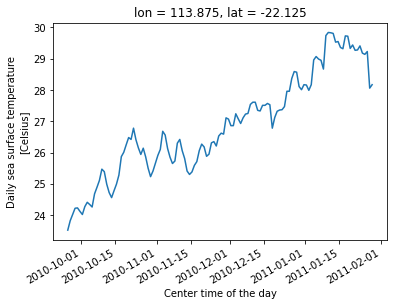

In [9]:
sst.sel(time=slice('2010-09-25', '2011-01-28')).plot()

In [10]:
# using climtas.event.find_events to identify days where severity>1 for a minimum of 3 consecutive days 
thw_events = climtas.event.find_events(thw['severity'] > 1, min_duration = 3)

In [11]:
thw_events

,time,event_duration
0,129,4
1,231,3
2,289,3
3,333,3
4,491,3
...,...,...
172,13241,5
173,13250,3
174,13254,6
175,13278,3


In [12]:
mhw_events = climtas.event.find_events(da_mhw > 1, min_duration = 5)

In [13]:
mhw_events

,time,event_duration
0,76,5
1,120,10
2,221,14
3,291,6
4,325,18
...,...,...
90,12843,11
91,12882,5
92,13040,6
93,13166,7


In [14]:
#Create a sparse array with (coords, values, shape)
mhw_duration_array = sparse.COO(mhw_events['time'], mhw_events['event_duration'], shape=da_mhw.shape)
mhw_duration_da = xr.DataArray(mhw_duration_array, coords=da_mhw.coords)
mhw_duration_da

Format,coo
Data Type,int64
Shape,"(13514,)"
nnz,95
Density,0.007029746929110552
Read-only,True
Size,1.5K
Storage ratio,0.0


In [15]:
#Create a sparse array with (coords, values, shape)
event_duration_array = sparse.COO(thw_events['time'], thw_events['event_duration'], shape=thw['severity'].shape)
event_duration_da = xr.DataArray(event_duration_array, coords=thw['severity'].coords)
event_duration_da

Format,coo
Data Type,int64
Shape,"(13514,)"
nnz,177
Density,0.013097528488974396
Read-only,True
Size,2.8K
Storage ratio,0.0


In [16]:
def get_coords(da, events):
    # Convert the index values to coordinates
    coords = {}
    for d in da.dims:
        coords[d] = da[d].values[events[d].values]
    
    # Also work out when the event ends
    coords['time_end'] = da['time'].values[events['time'].values + events['event_duration'].values-1]
    #coords['event_duration'] = coords['time_end'] - coords['time'] 
    coords['event_duration'] = events['event_duration'].values
    
    return pd.DataFrame(coords, index=events.index)

In [17]:
mhw_new = get_coords(mhw_duration_da, mhw_events)

In [18]:
# 2 days prior to start date and 2 days after end date

#mhw_new.rename(columns={"time": "time_mhw", "time_end": "time_end_mhw", "event_duration": "event_duration_mhw"}, inplace=True)
mhw_new['time'] = (mhw_new['time'] - np.timedelta64(2, 'D'))
mhw_new['time_end'] = (mhw_new['time_end'] + np.timedelta64(2, 'D'))
mhw_new['event_duration'] = (mhw_new['event_duration'] + 4)

In [19]:
all_mhw = mhw_new.reset_index()
all_mhw['time'] = ((mhw_new.time - (pd.to_datetime('1982-1-1')))/np.timedelta64(1, 'D')).astype(int)

In [20]:
mhw_max_sst = climtas.event.map_events(sst, all_mhw, lambda x: {'max_sst': x.max().item(), 'time_peak_mhw': x.idxmax().values})
mhw_max_sst['time_peak_mhw'] = mhw_max_sst['time_peak_mhw'].dt.date.astype('datetime64')

In [21]:
all_mhw = mhw_new.reset_index()
all_mhw = all_mhw.rename(columns={"time":"time_mhw", "time_end":"time_end_mhw", "event_duration":"event_duration_mhw"})
del all_mhw['index']

In [22]:
all_mhw_peak = all_mhw.join(mhw_max_sst)

In [23]:
all_mhw_buildup = all_mhw_peak[['time_mhw', 'time_peak_mhw']].copy()

In [24]:
all_mhw_decay = all_mhw_peak[['time_peak_mhw', 'time_end_mhw']].copy()

In [25]:
thw_new = get_coords(event_duration_da, thw_events)

In [26]:
#Calculating the overlap between THW and MHW buildup phase 

Range = namedtuple('Range', ['start', 'end'])
thw_mod_b = pd.DataFrame(columns=['time', 'time_end', 'event_duration', 'time_mhw', 'time_end_mhw'])
for t in range (thw_new.shape[0]):
    for m in range(all_mhw_buildup.shape[0]):
        thw = Range(start=thw_new['time'].iloc[t], end=thw_new['time_end'].iloc[t])
        mhw = Range(start=all_mhw_buildup['time_mhw'].iloc[m], end=all_mhw_buildup['time_peak_mhw'].iloc[m])
        if thw.start >= mhw.start and mhw.end >= thw.end:
            thw_mod_b = thw_mod_b.append([{'time':thw_new['time'].iloc[t], 'time_end':thw_new['time_end'].iloc[t], 'event_duration':thw_new['event_duration'].iloc[t], 'time_mhw':all_mhw_buildup['time_mhw'].iloc[m], 'time_end_mhw':all_mhw_buildup['time_peak_mhw'].iloc[m]}], ignore_index=True)

In [27]:
co_mhw_buildup = thw_mod_b[['time_mhw', 'time_end_mhw']]
co_mhw_buildup = co_mhw_buildup.drop_duplicates()
co_mhw_buildup = co_mhw_buildup.reset_index()

In [28]:
co_mhw_buildup['event_duration_mhw'] = ((co_mhw_buildup['time_end_mhw'] - co_mhw_buildup['time_mhw']).dt.days)+1

In [29]:
# stand-alone mhw buildup will be the difference between all MHW buildup events and co-occurring events 
st_mhw_buildup=all_mhw_buildup.merge(co_mhw_buildup,indicator = True, how='left').loc[lambda x : x['_merge']!='both']

In [30]:
st_mhw_buildup = st_mhw_buildup.reset_index()
del st_mhw_buildup['level_0']
del st_mhw_buildup['index']
del st_mhw_buildup['time_end_mhw']
del st_mhw_buildup['event_duration_mhw']
del st_mhw_buildup['_merge']

In [32]:
st_mhw_buildup.to_csv('st-mhw-buildup-nin.csv')

In [31]:
#Calculating the overlap between THW and MHW decay phase 

Range = namedtuple('Range', ['start', 'end'])
thw_mod_d = pd.DataFrame(columns=['time', 'time_end', 'event_duration', 'time_mhw', 'time_end_mhw'])
for t in range (thw_new.shape[0]):
    for m in range(all_mhw_decay.shape[0]):
        thw = Range(start=thw_new['time'].iloc[t], end=thw_new['time_end'].iloc[t])
        mhw = Range(start=all_mhw_decay['time_peak_mhw'].iloc[m], end=all_mhw_decay['time_end_mhw'].iloc[m])
        if thw.start >= mhw.start and mhw.end >= thw.end:
            thw_mod_d = thw_mod_d.append([{'time':thw_new['time'].iloc[t], 'time_end':thw_new['time_end'].iloc[t], 'event_duration':thw_new['event_duration'].iloc[t], 'time_mhw':all_mhw_decay['time_peak_mhw'].iloc[m], 'time_end_mhw':all_mhw_decay['time_end_mhw'].iloc[m]}], ignore_index=True)

In [32]:
co_mhw_decay = thw_mod_d[['time_mhw', 'time_end_mhw']]
co_mhw_decay = co_mhw_decay.drop_duplicates()
co_mhw_decay = co_mhw_decay.reset_index()

In [33]:
co_mhw_decay['event_duration_mhw'] = ((co_mhw_decay['time_end_mhw'] - co_mhw_decay['time_mhw']).dt.days)+1

In [34]:
# stand-alone mhw decay will be the difference between all MHW decay events and co-occurring events 
st_mhw_decay=all_mhw_decay.merge(co_mhw_decay,indicator = True, how='left').loc[lambda x : x['_merge']!='both']

In [35]:
st_mhw_decay = st_mhw_decay.reset_index()
del st_mhw_decay['level_0']
del st_mhw_decay['index']
del st_mhw_decay['time_mhw']
del st_mhw_decay['event_duration_mhw']
del st_mhw_decay['_merge']

In [36]:
st_mhw_decay.to_csv('st-mhw-decay-nin.csv')

## Co-occurring events 

In [41]:
# MSLP anomalies 

ds = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-MSL/msl_anom.nc')
mslp_anom = ds['msl_anomaly']

In [42]:
mslpa_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], mslp_anom.shape[1], mslp_anom.shape[2])), dims=['event', 'lat', 'lon'])
mslpa_buildup['lat'] = mslp_anom['latitude'].values
mslpa_buildup['lon'] = mslp_anom['longitude'].values
mslpa_buildup['event'] = st_mhw_buildup.index.values

In [43]:
mslpa_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], mslp_anom.shape[1], mslp_anom.shape[2])), dims=['event', 'lat', 'lon'])
mslpa_decay['lat'] = mslp_anom['latitude'].values
mslpa_decay['lon'] = mslp_anom['longitude'].values
mslpa_decay['event'] = st_mhw_decay.index.values

In [82]:
mslpa_co_buildup = xr.DataArray(np.zeros((thw_mod_b.shape[0], mslp_anom.shape[1], mslp_anom.shape[2])), dims=['event', 'lat', 'lon'])
mslpa_co_buildup['lat'] = mslp_anom['latitude'].values
mslpa_co_buildup['lon'] = mslp_anom['longitude'].values
mslpa_co_buildup['event'] = thw_mod_b.index.values

In [83]:
mslpa_co_decay = xr.DataArray(np.zeros((thw_mod_d.shape[0], mslp_anom.shape[1], mslp_anom.shape[2])), dims=['event', 'lat', 'lon'])
mslpa_co_decay['lat'] = mslp_anom['latitude'].values
mslpa_co_decay['lon'] = mslp_anom['longitude'].values
mslpa_co_decay['event'] = thw_mod_d.index.values

In [84]:
mslpa_co_mhw_buildup = xr.DataArray(np.zeros((co_mhw_buildup.shape[0], mslp_anom.shape[1], mslp_anom.shape[2])), dims=['event', 'lat', 'lon'])
mslpa_co_mhw_buildup['lat'] = mslp_anom['latitude'].values
mslpa_co_mhw_buildup['lon'] = mslp_anom['longitude'].values
mslpa_co_mhw_buildup['event'] = co_mhw_buildup.index.values

In [85]:
mslpa_co_mhw_decay = xr.DataArray(np.zeros((co_mhw_decay.shape[0], mslp_anom.shape[1], mslp_anom.shape[2])), dims=['event', 'lat', 'lon'])
mslpa_co_mhw_decay['lat'] = mslp_anom['latitude'].values
mslpa_co_mhw_decay['lon'] = mslp_anom['longitude'].values
mslpa_co_mhw_decay['event'] = co_mhw_decay.index.values

In [44]:
for i, e in enumerate(st_mhw_buildup.itertuples()):
    mslpa_buildup[i, :, :] = mslp_anom.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')
    
for i, e in enumerate(st_mhw_decay.itertuples()):
    mslpa_decay[i, :, :] = mslp_anom.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')

In [87]:
for i, e in enumerate(thw_mod_b.itertuples()):
    mslpa_co_buildup[i, :, :] = mslp_anom.sel(time=slice(e.time, e.time_end)).mean('time')
    
for i, e in enumerate(thw_mod_d.itertuples()):
    mslpa_co_decay[i, :, :] = mslp_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [88]:
for i, e in enumerate(co_mhw_buildup.itertuples()):
    mslpa_co_mhw_buildup[i, :, :] = mslp_anom.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')
    
for i, e in enumerate(co_mhw_decay.itertuples()):
    mslpa_co_mhw_decay[i, :, :] = mslp_anom.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [62]:
# SST anomalies 

files = glob.glob('/g/data/e14/cp3790/Charuni/MHW-updated/mhw_severity.pc90.*.nc')
sst = xr.open_mfdataset(files, combine='by_coords').sel(time=slice('1982', '2018'), lon=slice(90, 180), lat=slice(-60, 0))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/coding/times.py:113: SerializationWarning: Ambiguous reference date string: 01-01-01 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [63]:
ssta = sst.ssta

In [64]:
ssta_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], ssta.shape[1], ssta.shape[2])), dims=['event', 'lat', 'lon'])
ssta_buildup['lat'] = ssta['lat'].values
ssta_buildup['lon'] = ssta['lon'].values
ssta_buildup['event'] = st_mhw_buildup.index.values

In [65]:
ssta_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], ssta.shape[1], ssta.shape[2])), dims=['event', 'lat', 'lon'])
ssta_decay['lat'] = ssta['lat'].values
ssta_decay['lon'] = ssta['lon'].values
ssta_decay['event'] = st_mhw_decay.index.values

In [93]:
ssta_co_buildup = xr.DataArray(np.zeros((thw_mod_b.shape[0], ssta.shape[1], ssta.shape[2])), dims=['event', 'lat', 'lon'])
ssta_co_buildup['lat'] = ssta['lat'].values
ssta_co_buildup['lon'] = ssta['lon'].values
ssta_co_buildup['event'] = thw_mod_b.index.values

In [94]:
ssta_co_decay = xr.DataArray(np.zeros((thw_mod_d.shape[0], ssta.shape[1], ssta.shape[2])), dims=['event', 'lat', 'lon'])
ssta_co_decay['lat'] = ssta['lat'].values
ssta_co_decay['lon'] = ssta['lon'].values
ssta_co_decay['event'] = thw_mod_d.index.values

In [112]:
ssta_co_mhw_buildup = xr.DataArray(np.zeros((co_mhw_buildup.shape[0], ssta.shape[1], ssta.shape[2])), dims=['event', 'lat', 'lon'])
ssta_co_mhw_buildup['lat'] = ssta['lat'].values
ssta_co_mhw_buildup['lon'] = ssta['lon'].values
ssta_co_mhw_buildup['event'] = co_mhw_buildup.index.values

In [111]:
ssta_co_mhw_decay = xr.DataArray(np.zeros((co_mhw_decay.shape[0], ssta.shape[1], ssta.shape[2])), dims=['event', 'lat', 'lon'])
ssta_co_mhw_decay['lat'] = ssta['lat'].values
ssta_co_mhw_decay['lon'] = ssta['lon'].values
ssta_co_mhw_decay['event'] = co_mhw_decay.index.values

In [49]:
for i, e in enumerate(st_mhw_buildup.itertuples()):
    ssta_buildup[i, :, :] = ssta.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')
    
for i, e in enumerate(st_mhw_decay.itertuples()):
    ssta_decay[i, :, :] = ssta.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')

In [98]:
for i, e in enumerate(thw_mod_b.itertuples()):
    ssta_co_buildup[i, :, :] = ssta.sel(time=slice(e.time, e.time_end)).mean('time')
    
for i, e in enumerate(thw_mod_d.itertuples()):
    ssta_co_decay[i, :, :] = ssta.sel(time=slice(e.time, e.time_end)).mean('time')

In [113]:
for i, e in enumerate(co_mhw_buildup.itertuples()):
    ssta_co_mhw_buildup[i, :, :] = ssta.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')
    
for i, e in enumerate(co_mhw_decay.itertuples()):
    ssta_co_mhw_decay[i, :, :] = ssta.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [50]:
# wind anomalies 

ds2 = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-WIND/u10/uwind_anom.nc')
uwind_anom = ds2.uwind_anomaly 
ds3 = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-WIND/v10/vwind_anom.nc')
vwind_anom = ds3.vwind_anomaly

In [51]:
uwind_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], uwind_anom.shape[1], uwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
uwind_buildup['lat'] = uwind_anom['latitude'].values
uwind_buildup['lon'] = uwind_anom['longitude'].values
uwind_buildup['event'] = st_mhw_buildup.index.values

In [52]:
uwind_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], uwind_anom.shape[1], uwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
uwind_decay['lat'] = uwind_anom['latitude'].values
uwind_decay['lon'] = uwind_anom['longitude'].values
uwind_decay['event'] = st_mhw_decay.index.values

In [103]:
uwind_co_buildup = xr.DataArray(np.zeros((thw_mod_b.shape[0], uwind_anom.shape[1], uwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
uwind_co_buildup['lat'] = uwind_anom['latitude'].values
uwind_co_buildup['lon'] = uwind_anom['longitude'].values
uwind_co_buildup['event'] = thw_mod_b.index.values

In [104]:
uwind_co_decay = xr.DataArray(np.zeros((thw_mod_d.shape[0], uwind_anom.shape[1], uwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
uwind_co_decay['lat'] = uwind_anom['latitude'].values
uwind_co_decay['lon'] = uwind_anom['longitude'].values
uwind_co_decay['event'] = thw_mod_d.index.values

In [105]:
uwind_co_mhw_buildup = xr.DataArray(np.zeros((co_mhw_buildup.shape[0], uwind_anom.shape[1], uwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
uwind_co_mhw_buildup['lat'] = uwind_anom['latitude'].values
uwind_co_mhw_buildup['lon'] = uwind_anom['longitude'].values
uwind_co_mhw_buildup['event'] = co_mhw_buildup.index.values

In [106]:
uwind_co_mhw_decay = xr.DataArray(np.zeros((co_mhw_decay.shape[0], uwind_anom.shape[1], uwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
uwind_co_mhw_decay['lat'] = uwind_anom['latitude'].values
uwind_co_mhw_decay['lon'] = uwind_anom['longitude'].values
uwind_co_mhw_decay['event'] = co_mhw_decay.index.values

In [53]:
for i, e in enumerate(st_mhw_buildup.itertuples()):
    uwind_buildup[i, :, :] = uwind_anom.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')
    
for i, e in enumerate(st_mhw_decay.itertuples()):
    uwind_decay[i, :, :] = uwind_anom.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')

In [108]:
for i, e in enumerate(thw_mod_b.itertuples()):
    uwind_co_buildup[i, :, :] = uwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')
    
for i, e in enumerate(thw_mod_d.itertuples()):
    uwind_co_decay[i, :, :] = uwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [109]:
for i, e in enumerate(co_mhw_buildup.itertuples()):
    uwind_co_mhw_buildup[i, :, :] = uwind_anom.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')
    
for i, e in enumerate(co_mhw_decay.itertuples()):
    uwind_co_mhw_decay[i, :, :] = uwind_anom.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [54]:
vwind_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], vwind_anom.shape[1], vwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
vwind_buildup['lat'] = vwind_anom['latitude'].values
vwind_buildup['lon'] = vwind_anom['longitude'].values
vwind_buildup['event'] = st_mhw_buildup.index.values

In [55]:
vwind_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], vwind_anom.shape[1], vwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
vwind_decay['lat'] = vwind_anom['latitude'].values
vwind_decay['lon'] = vwind_anom['longitude'].values
vwind_decay['event'] = st_mhw_decay.index.values

In [112]:
vwind_co_buildup = xr.DataArray(np.zeros((thw_mod_b.shape[0], vwind_anom.shape[1], vwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
vwind_co_buildup['lat'] = vwind_anom['latitude'].values
vwind_co_buildup['lon'] = vwind_anom['longitude'].values
vwind_co_buildup['event'] = thw_mod_b.index.values

In [113]:
vwind_co_decay = xr.DataArray(np.zeros((thw_mod_d.shape[0], vwind_anom.shape[1], vwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
vwind_co_decay['lat'] = vwind_anom['latitude'].values
vwind_co_decay['lon'] = vwind_anom['longitude'].values
vwind_co_decay['event'] = thw_mod_d.index.values

In [114]:
vwind_co_mhw_buildup = xr.DataArray(np.zeros((co_mhw_buildup.shape[0], vwind_anom.shape[1], vwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
vwind_co_mhw_buildup['lat'] = vwind_anom['latitude'].values
vwind_co_mhw_buildup['lon'] = vwind_anom['longitude'].values
vwind_co_mhw_buildup['event'] = co_mhw_buildup.index.values

In [115]:
vwind_co_mhw_decay = xr.DataArray(np.zeros((co_mhw_decay.shape[0], vwind_anom.shape[1], vwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
vwind_co_mhw_decay['lat'] = vwind_anom['latitude'].values
vwind_co_mhw_decay['lon'] = vwind_anom['longitude'].values
vwind_co_mhw_decay['event'] = co_mhw_decay.index.values

In [56]:
for i, e in enumerate(st_mhw_buildup.itertuples()):
    vwind_buildup[i, :, :] = vwind_anom.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')
    
for i, e in enumerate(st_mhw_decay.itertuples()):
    vwind_decay[i, :, :] = vwind_anom.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')

In [117]:
for i, e in enumerate(thw_mod_b.itertuples()):
    vwind_co_buildup[i, :, :] = vwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')
    
for i, e in enumerate(thw_mod_d.itertuples()):
    vwind_co_decay[i, :, :] = vwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [118]:
for i, e in enumerate(co_mhw_buildup.itertuples()):
    vwind_co_mhw_buildup[i, :, :] = vwind_anom.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')
    
for i, e in enumerate(co_mhw_decay.itertuples()):
    vwind_co_mhw_decay[i, :, :] = vwind_anom.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [57]:
x = uwind_anom['longitude']
y = vwind_anom['latitude']

In [58]:
# SAT anomalies (ocean+land)
sat = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-TEMP/tmax_anom.nc').sel(longitude=slice(90, 180), latitude=slice(0, -60))

In [59]:
sata = sat.tmax_anomaly

In [60]:
sata_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], sata.shape[1], sata.shape[2])), dims=['event', 'lat', 'lon'])
sata_buildup['lat'] = sata['latitude'].values
sata_buildup['lon'] = sata['longitude'].values
sata_buildup['event'] = st_mhw_buildup.index.values

In [61]:
sata_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], sata.shape[1], sata.shape[2])), dims=['event', 'lat', 'lon'])
sata_decay['lat'] = sata['latitude'].values
sata_decay['lon'] = sata['longitude'].values
sata_decay['event'] = st_mhw_decay.index.values

In [124]:
sata_co_buildup = xr.DataArray(np.zeros((thw_mod_b.shape[0], sata.shape[1], sata.shape[2])), dims=['event', 'lat', 'lon'])
sata_co_buildup['lat'] = sata['latitude'].values
sata_co_buildup['lon'] = sata['longitude'].values
sata_co_buildup['event'] = thw_mod_b.index.values

In [125]:
sata_co_decay = xr.DataArray(np.zeros((thw_mod_d.shape[0], sata.shape[1], sata.shape[2])), dims=['event', 'lat', 'lon'])
sata_co_decay['lat'] = sata['latitude'].values
sata_co_decay['lon'] = sata['longitude'].values
sata_co_decay['event'] = thw_mod_d.index.values

In [126]:
sata_co_mhw_buildup = xr.DataArray(np.zeros((co_mhw_buildup.shape[0], sata.shape[1], sata.shape[2])), dims=['event', 'lat', 'lon'])
sata_co_mhw_buildup['lat'] = sata['latitude'].values
sata_co_mhw_buildup['lon'] = sata['longitude'].values
sata_co_mhw_buildup['event'] = co_mhw_buildup.index.values

In [127]:
sata_co_mhw_decay = xr.DataArray(np.zeros((co_mhw_decay.shape[0], sata.shape[1], sata.shape[2])), dims=['event', 'lat', 'lon'])
sata_co_mhw_decay['lat'] = sata['latitude'].values
sata_co_mhw_decay['lon'] = sata['longitude'].values
sata_co_mhw_decay['event'] = co_mhw_decay.index.values

In [62]:
for i, e in enumerate(st_mhw_buildup.itertuples()):
    sata_buildup[i, :, :] = sata.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')
    
for i, e in enumerate(st_mhw_decay.itertuples()):
    sata_decay[i, :, :] = sata.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')

In [129]:
for i, e in enumerate(thw_mod_b.itertuples()):
    sata_co_buildup[i, :, :] = sata.sel(time=slice(e.time, e.time_end)).mean('time')
    
for i, e in enumerate(thw_mod_d.itertuples()):
    sata_co_decay[i, :, :] = sata.sel(time=slice(e.time, e.time_end)).mean('time')

In [130]:
for i, e in enumerate(co_mhw_buildup.itertuples()):
    sata_co_mhw_buildup[i, :, :] = sata.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')
    
for i, e in enumerate(co_mhw_decay.itertuples()):
    sata_co_mhw_decay[i, :, :] = sata.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [259]:
def composite_plot(mslpa_c, sata_c, uwind_c, vwind_c, figname):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([105, 125, -30, -15],crs=ccrs.PlateCarree())
    ax.set_xticks([105, 110, 115, 120, 125], crs=ccrs.PlateCarree())
    ax.set_yticks([-30, -25, -20, -15], crs=ccrs.PlateCarree())

    im = sata_c.mean(dim='event').plot.contourf(
                levels=np.arange(-6,6.105,1), 
                add_colorbar=False,
                cmap=plt.cm.get_cmap('coolwarm', 12))
    
    cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-6,6.11,1),fraction=0.035,aspect=30) #,format='%.2f')
    cb.set_label(label=u'Surface air temperature anomaly (\u00B0C)', size=22, weight='normal')
    cb.ax.tick_params(labelsize=20)
    
    ploteo2=mslpa_c.mean(dim='event').plot.contour(
                colors='k',
                levels=30
           )

    ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')

    # Plotting every 10th data point 
    q = ax.quiver(x[::5], y[::5], uwind_c.mean(dim='event')[::5, ::5], vwind_c.mean(dim='event')[::5, ::5], scale=25, units='height', headwidth=7, headlength=5, headaxislength=4.5)
    plt.quiverkey(q, 0.1, 1.02, 2.5, '2.5 m/s', labelpos='E', fontproperties={'size':20})
    plt.ylabel('Latitude', fontsize=20)
    plt.xlabel('Longitude', fontsize=20)

    # Adding panel subplot alphabet label 
    #ax.text(0.95,1.05,'(%s)' %(ascii_lowercase[b]),
            #horizontalalignment='left',verticalalignment='top',
            #transform = ax.transAxes,fontweight='normal', fontsize=22)
    plt.plot(113.8, -22.1,  markersize=12, marker='o', color='purple')
    plt.savefig(figname)

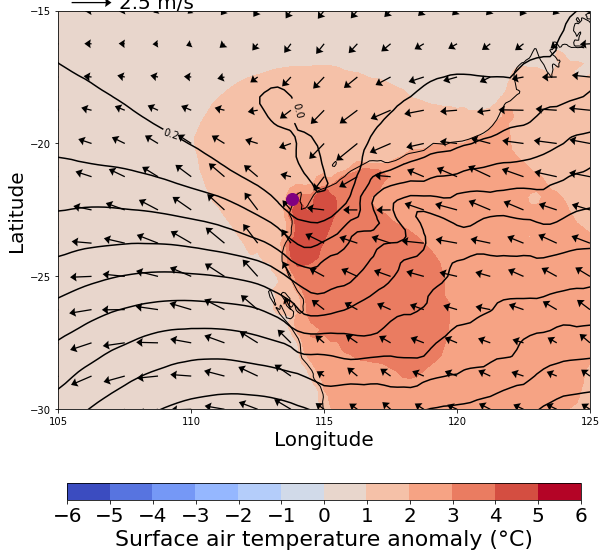

In [260]:
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-mslpa-thw.png'
composite_plot(mslpa_nco, sata_nco, uwind_nco, vwind_nco, savefig)

## Stand-alone THW events 

In [37]:
# concatenate thw overlapping with mhw buildup and decay phases to get total co-occurring THW events
co_thw = pd.concat([thw_mod_b, thw_mod_d])

In [38]:
del co_thw['time_mhw']
del co_thw['time_end_mhw']

In [39]:
co_thw = co_thw.sort_values('time')
co_thw = co_thw.reset_index()
del co_thw['index']

In [40]:
# stand-alone events will be the difference between all THW events and co-occurring events 
st_thw=thw_new.merge(co_thw,indicator = True, how='left').loc[lambda x : x['_merge']!='both']

In [41]:
stand_alone = st_thw.reset_index()

In [42]:
del stand_alone['index']
del stand_alone['_merge']

In [268]:
print(stand_alone.loc[stand_alone['event_duration']==4])

          time   time_end event_duration
0   1982-05-10 1982-05-13              4
3   1983-05-27 1983-05-30              4
7   1983-10-21 1983-10-24              4
13  1985-01-07 1985-01-10              4
21  1987-08-15 1987-08-18              4
23  1988-02-28 1988-03-02              4
27  1988-10-11 1988-10-14              4
35  1990-11-25 1990-11-28              4
38  1991-08-10 1991-08-13              4
45  1994-08-15 1994-08-18              4
46  1994-08-24 1994-08-27              4
47  1994-09-06 1994-09-09              4
49  1995-08-26 1995-08-29              4
50  1996-04-26 1996-04-29              4
57  1998-03-02 1998-03-05              4
65  2000-09-16 2000-09-19              4
70  2003-01-19 2003-01-22              4
83  2006-03-20 2006-03-23              4
89  2007-02-12 2007-02-15              4
90  2007-02-23 2007-02-26              4
100 2009-01-17 2009-01-20              4
101 2009-04-02 2009-04-05              4
103 2009-10-17 2009-10-20              4
104 2009-11-01 2

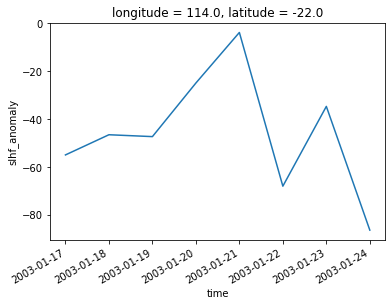

In [368]:
slhf.sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice('2003-01-17', '2003-01-24')).plot()

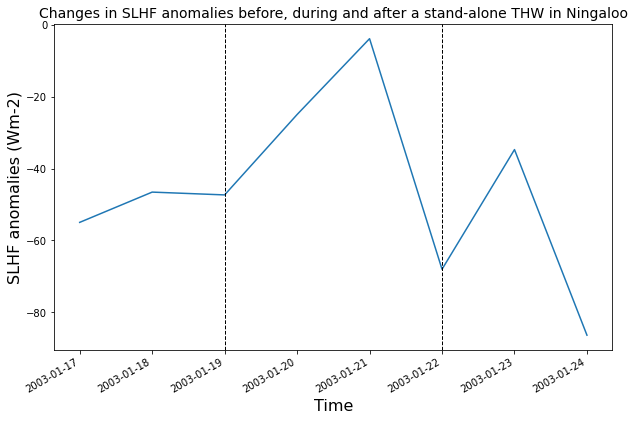

In [377]:
import datetime as dt
fig, ax = plt.subplots(figsize=(10,6)) 

#sns.distplot(mc_aus_100.sel(latitude=lat, longitude=lon), hist=False, kde=True, kde_kws = {'shade': False, 'linewidth': 3}, color='black', label='PDF of MC simulations')

#plt.axvline(x=mc_aus_100.quantile(0.99, dim='Repeats').sel(latitude=lat, longitude=lon), color='g', linewidth=4, label='99th percentile of distribution')
#plt.plot(slhf.sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice('2013-09-01', '2013-09-08')))
slhf.sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice('2003-01-17', '2003-01-24')).plot()
plt.axvline((dt.datetime(2003, 1, 19)), color='k', linewidth=1, linestyle='--')
plt.axvline((dt.datetime(2003, 1, 22)), color='k', linewidth=1, linestyle='--')

plt.ylabel('SLHF anomalies (Wm-2)', fontsize=16)
plt.title('Changes in SLHF anomalies before, during and after a stand-alone THW in Ningaloo', fontsize=14)
plt.xlabel('Time', fontsize=16)
plt.savefig('/g/data/e14/cp3790/Charuni/Plots/New/nin-slhf-evo.png')
#plt.show()

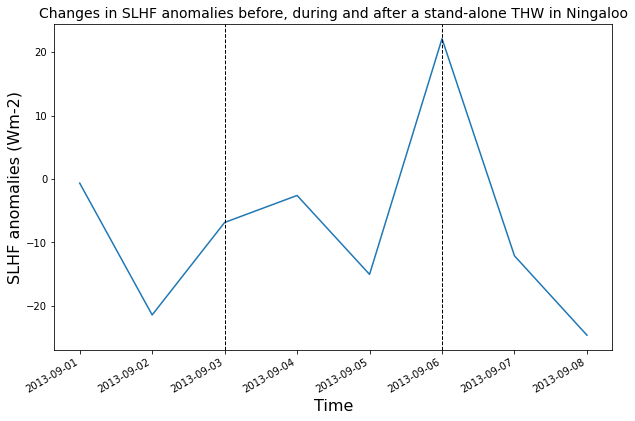

In [376]:
fig, ax = plt.subplots(figsize=(10,6)) 

#sns.distplot(mc_aus_100.sel(latitude=lat, longitude=lon), hist=False, kde=True, kde_kws = {'shade': False, 'linewidth': 3}, color='black', label='PDF of MC simulations')

#plt.axvline(x=mc_aus_100.quantile(0.99, dim='Repeats').sel(latitude=lat, longitude=lon), color='g', linewidth=4, label='99th percentile of distribution')
#plt.plot(slhf.sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice('2013-09-01', '2013-09-08')))
slhf.sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice('2013-09-01', '2013-09-08')).plot()
plt.axvline((dt.datetime(2013, 9, 3)), color='k', linewidth=1, linestyle='--')
plt.axvline((dt.datetime(2013, 9, 6)), color='k', linewidth=1, linestyle='--')

plt.ylabel('SLHF anomalies (Wm-2)', fontsize=16)
plt.title('Changes in SLHF anomalies before, during and after a stand-alone THW in Ningaloo', fontsize=14)
plt.xlabel('Time', fontsize=16)
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/New/NN-mc.png')
plt.show()

In [297]:
autumn = stand_alone.loc[(stand_alone['time'].dt.month.between(3,5))]

winter = stand_alone.loc[(stand_alone['time'].dt.month.between(6,8))]

spring = stand_alone.loc[(stand_alone['time'].dt.month.between(9,11))]

summer = stand_alone.loc[~(stand_alone['time'].dt.month.between(3,11))]

In [341]:
print(autumn['event_duration'].mean())

print(winter['event_duration'].mean())

print(spring['event_duration'].mean())

print(summer['event_duration'].mean())

3.880952380952381
4.146341463414634
4.4
3.92


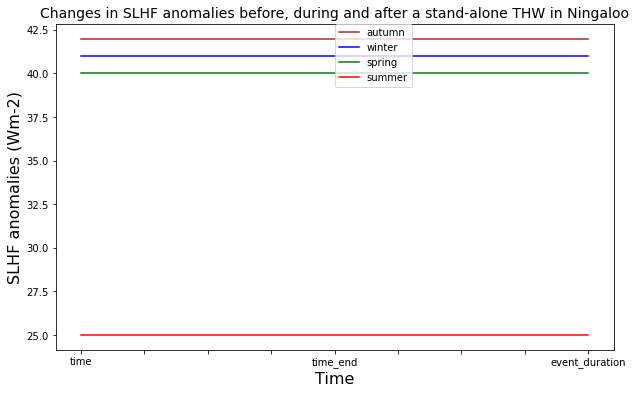

In [333]:
fig, ax = plt.subplots(figsize=(10,6)) 

autumn.count().plot(color='brown', label='autumn')
winter.count().plot(color='blue', label='winter')
spring.count().plot(color='green', label='spring')
summer.count().plot(color='red', label='summer')

plt.ylabel('SLHF anomalies (Wm-2)', fontsize=16)
plt.title('Changes in SLHF anomalies before, during and after a stand-alone THW in Ningaloo', fontsize=14)
plt.xlabel('Time', fontsize=16)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper left', borderaxespad=0.)
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/New/NN-mc.png')
plt.show()

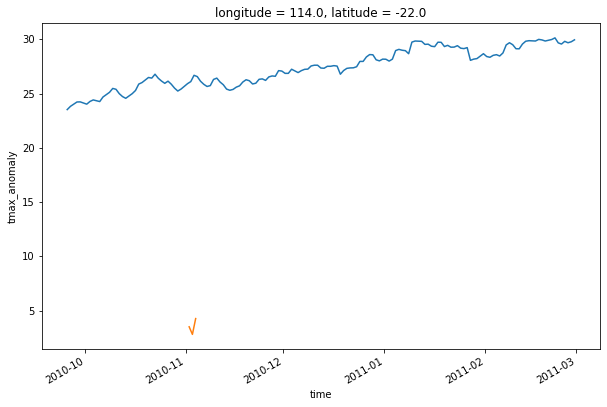

In [75]:
fig, ax = plt.subplots(figsize=(10,6)) 
sst.sel(time=slice('2010-09-25', '2011-02-28')).plot()
nin.sel(time=slice('2010-11-02', '2010-11-04')).plot()

In [74]:
nin = sata.sel(latitude=lat, longitude=lon, method='nearest')
#time=slice('2010-09-25', '2011-01-28')).plot()

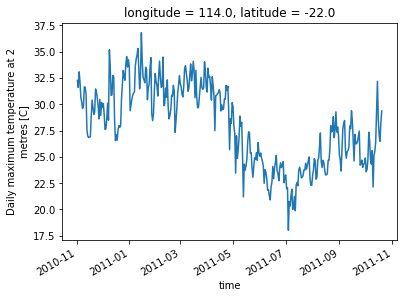

In [355]:
nin.sel(time=slice('2010-11-02', '201011-04')).plot()

## Stand-alone THW | before and after

In [45]:
stand_alone

,time,time_end,event_duration
0,1982-05-10,1982-05-13,4
1,1982-08-20,1982-08-22,3
2,1983-05-07,1983-05-09,3
3,1983-05-27,1983-05-30,4
4,1983-07-03,1983-07-05,3
...,...,...,...
143,2018-04-03,2018-04-07,5
144,2018-04-12,2018-04-14,3
145,2018-04-16,2018-04-21,6
146,2018-05-10,2018-05-12,3


In [46]:
stand_alone_prior = stand_alone.copy()

In [47]:
# 2 days prior to THW start date 

stand_alone_prior['time'] = (stand_alone['time'] - np.timedelta64(2, 'D'))
stand_alone_prior['time_end'] = stand_alone['time']
del stand_alone_prior['event_duration']
stand_alone_prior

,time,time_end
0,1982-05-08,1982-05-10
1,1982-08-18,1982-08-20
2,1983-05-05,1983-05-07
3,1983-05-25,1983-05-27
4,1983-07-01,1983-07-03
...,...,...
143,2018-04-01,2018-04-03
144,2018-04-10,2018-04-12
145,2018-04-14,2018-04-16
146,2018-05-08,2018-05-10


In [48]:
stand_alone_post = stand_alone.copy()

In [49]:
# 2 days after THW end date 

stand_alone_post['time'] = stand_alone['time_end'] 
stand_alone_post['time_end'] = (stand_alone['time_end'] + np.timedelta64(2, 'D'))
del stand_alone_post['event_duration']
stand_alone_post

,time,time_end
0,1982-05-13,1982-05-15
1,1982-08-22,1982-08-24
2,1983-05-09,1983-05-11
3,1983-05-30,1983-06-01
4,1983-07-05,1983-07-07
...,...,...
143,2018-04-07,2018-04-09
144,2018-04-14,2018-04-16
145,2018-04-21,2018-04-23
146,2018-05-12,2018-05-14


In [211]:
# MSLP anomalies 

mslpa_nco = xr.DataArray(np.zeros((stand_alone.shape[0], mslp_anom.shape[1], mslp_anom.shape[2])), dims=['event', 'lat', 'lon'])
mslpa_nco['lat'] = mslp_anom['latitude'].values
mslpa_nco['lon'] = mslp_anom['longitude'].values
mslpa_nco['event'] = stand_alone.index.values

In [212]:
for i, e in enumerate(stand_alone.itertuples()):
    mslpa_nco[i, :, :] = mslp_anom.sel(time=slice(e.time, e.time_end)).mean('time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/c

In [165]:
# SST anomalies 

ssta_nco = xr.DataArray(np.zeros((stand_alone.shape[0], ssta.shape[1], ssta.shape[2])), dims=['event', 'lat', 'lon'])
ssta_nco['lat'] = ssta['lat'].values
ssta_nco['lon'] = ssta['lon'].values
ssta_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    ssta_nco[i, :, :] = ssta.sel(time=slice(e.time, e.time_end)).mean('time')

In [221]:
# SAT abs

sat = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-TEMP/era5_dailytmax_*.nc').sel(longitude=slice(90, 180), latitude=slice(0, -60))
sata = sat.tmax - 273.15
sata.attrs = sat.tmax.attrs
sata.attrs["units"] = "C"

In [247]:
sat = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-TEMP/era5_sat_1982_2018.nc')
sata = sat.sat

In [41]:
# SAT anomalies (ocean+land)

sat = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-TEMP/tmax_anom.nc').sel(longitude=slice(90, 180), latitude=slice(0, -60))
sata = sat.tmax_anomaly

In [42]:
# SAT abs/anomalies

sata_nco = xr.DataArray(np.zeros((stand_alone.shape[0], sata.shape[1], sata.shape[2])), dims=['event', 'lat', 'lon'])
sata_nco['lat'] = sata['latitude'].values
sata_nco['lon'] = sata['longitude'].values
sata_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    sata_nco[i, :, :] = sata.sel(time=slice(e.time, e.time_end)).mean('time')

In [215]:
# uwind anomalies 

uwind_nco = xr.DataArray(np.zeros((stand_alone.shape[0], uwind_anom.shape[1], uwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
uwind_nco['lat'] = uwind_anom['latitude'].values
uwind_nco['lon'] = uwind_anom['longitude'].values
uwind_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    uwind_nco[i, :, :] = uwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [216]:
# vwind anomalies 

vwind_nco = xr.DataArray(np.zeros((stand_alone.shape[0], vwind_anom.shape[1], vwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
vwind_nco['lat'] = vwind_anom['latitude'].values
vwind_nco['lon'] = vwind_anom['longitude'].values
vwind_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    vwind_nco[i, :, :] = vwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [217]:
x = uwind_anom['longitude']
y = vwind_anom['latitude']

In [218]:
slhfa_nco = xr.DataArray(np.zeros((stand_alone.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_nco['lat'] = slhf['latitude'].values
slhfa_nco['lon'] = slhf['longitude'].values
slhfa_nco['event'] = stand_alone.index.values
    
for i, e in enumerate(stand_alone.itertuples()):
    slhfa_nco[i, :, :] = slhf.sel(time=slice(e.time, e.time_end)).mean('time')

In [219]:
ws_nco = xr.DataArray(np.zeros((stand_alone.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_nco['lat'] = wind_speed_anom['latitude'].values
ws_nco['lon'] = wind_speed_anom['longitude'].values
ws_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    ws_nco[i, :, :] = wind_speed_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [378]:
# abs swvl1

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-LAND/era5_swvl1_1982_2018.nc')
swvl1 = ds.swvl1

In [47]:
# swvl1 anomalies 

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-LAND/swvl1_anom.nc')
swvl1 = ds.swvl1_anomaly

In [48]:
swvl1_nco = xr.DataArray(np.zeros((stand_alone.shape[0], swvl1.shape[1], swvl1.shape[2])), dims=['event', 'lat', 'lon'])
swvl1_nco['lat'] = swvl1['latitude'].values
swvl1_nco['lon'] = swvl1['longitude'].values
swvl1_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    swvl1_nco[i, :, :] = swvl1.sel(time=slice(e.time, e.time_end)).mean('time')

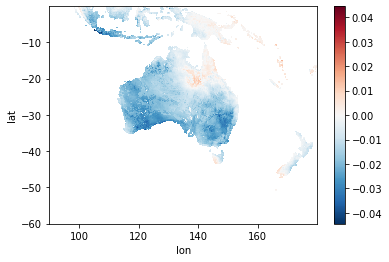

In [49]:
swvl1_nco.mean(dim='event').plot()

In [57]:
# vertical velocity anomalies

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-W/w_anom.nc')
w= ds.w_anomaly

In [58]:
w_nco = xr.DataArray(np.zeros((stand_alone.shape[0], w.shape[1], w.shape[2])), dims=['event', 'lat', 'lon'])
w_nco['lat'] = w['latitude'].values
w_nco['lon'] = w['longitude'].values
w_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    w_nco[i, :, :] = w.sel(time=slice(e.time, e.time_end)).mean('time')

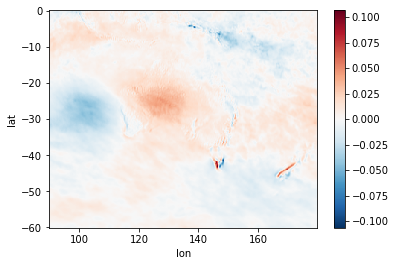

In [59]:
w_nco.mean(dim='event').plot()

In [117]:
def composite_plot(w_c, figname):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([90, 180, -50, 0],crs=ccrs.PlateCarree())
    ax.set_xticks([90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0], crs=ccrs.PlateCarree())

    im = w_c.mean(dim='event').plot.contourf(
                levels=np.arange(-0.1,0.105,0.025), 
                add_colorbar=False,
                cmap=plt.cm.get_cmap('coolwarm', 8))
    
    cb = plt.colorbar(im, orientation="vertical",ticks=np.arange(-0.1,0.11,0.025),fraction=0.035,aspect=30) #,format='%.2f')
    cb.set_label(label=u'Vertical velocity at 500 hPa (Pa/s)', size=22, weight='normal')
    cb.ax.tick_params(labelsize=16)

    plt.ylabel('Latitude', fontsize=20)
    plt.xlabel('Longitude', fontsize=20)

    plt.plot(113.8, -22.1,  markersize=12, marker='o', color='purple')
    plt.savefig(figname)

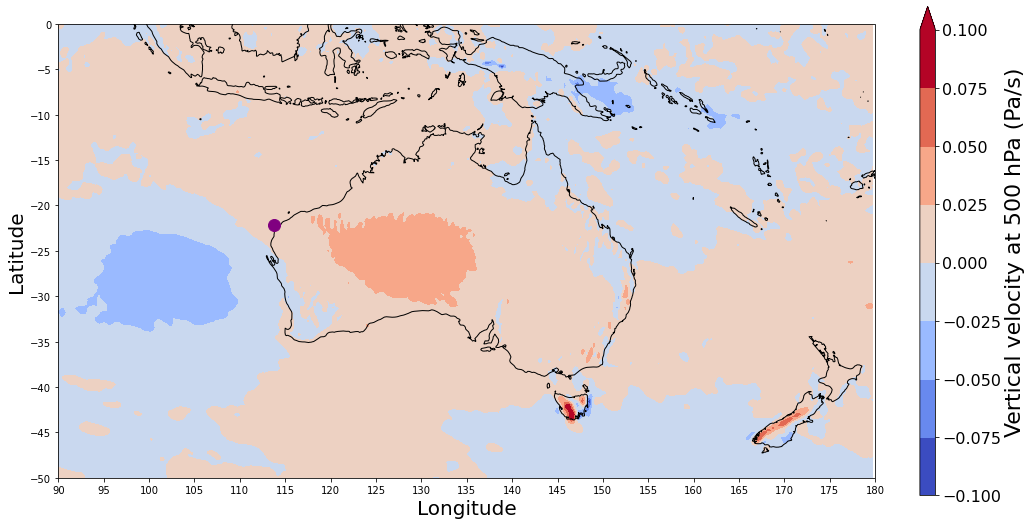

In [118]:
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-vv-thw.png'
composite_plot(w_nco, savefig)

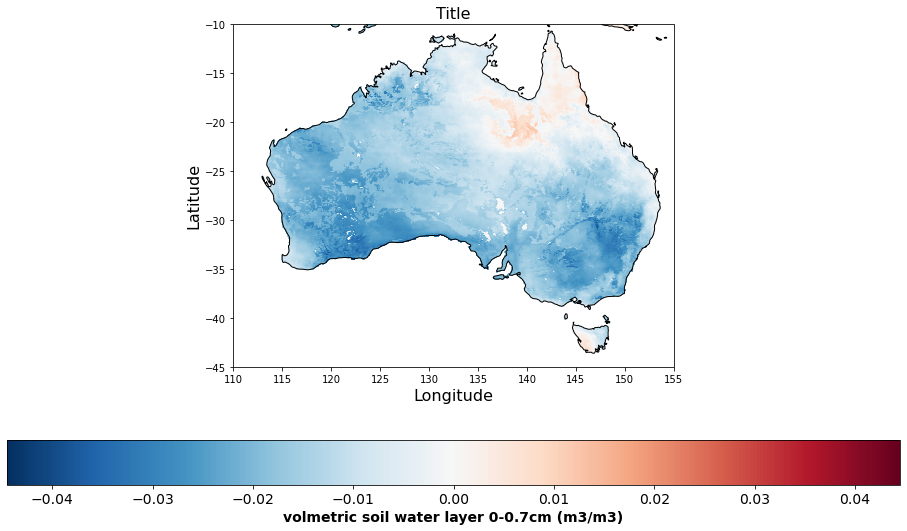

In [178]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([110, 115, 120, 125, 130, 135, 140, 145, 150, 155], crs=ccrs.PlateCarree())
ax.set_yticks([-45, -40, -35, -30, -25, -20, -15, -10], crs=ccrs.PlateCarree())
    
im = swvl1_nco.mean(dim='event').plot.pcolormesh(add_colorbar=False)
cb = plt.colorbar(im, orientation="horizontal")
cb.set_label(label='volmetric soil water layer 0-0.7cm (m3/m3)', size=14, weight='bold')
cb.ax.tick_params(labelsize=14)

    
ax.coastlines()
ax.set_extent([110, 155, -45, -10],crs=ccrs.PlateCarree())    
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('Title', fontsize=16, loc='center')
plt.show()

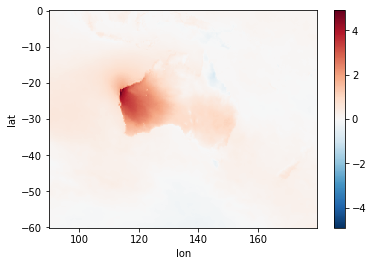

In [43]:
sata_nco.mean(dim='event').plot()

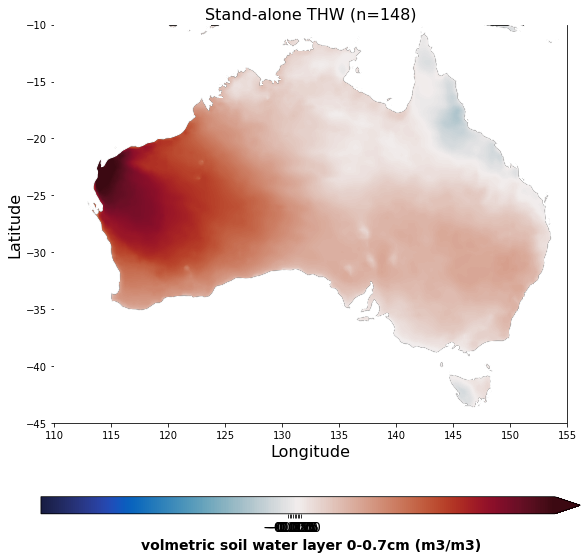

In [56]:
# DC helped with this, to customize the colour bar
import cartopy.feature as cfeature
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([110, 155, -45, -10],crs=ccrs.PlateCarree())    
ax.set_xticks([110, 115, 120, 125, 130, 135, 140, 145, 150, 155], crs=ccrs.PlateCarree())
ax.set_yticks([-45, -40, -35, -30, -25, -20, -15, -10], crs=ccrs.PlateCarree())


ax.add_feature(cfeature.OCEAN, zorder=100, facecolor='white')#('physical', 'land', '50m',
                                                #edgecolor='none', facecolor="white"), zorder=1)  

im = sata_nco.mean(dim='event').plot.contourf(levels=np.arange(-4,4.105,0.01), add_colorbar=False,
                                              cmap=cmocean.cm.balance)

ax.coastlines()
cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-0.1,0.11,0.025),fraction=0.035,aspect=30) #,format='%.2f')
cb.set_label(label='volmetric soil water layer 0-0.7cm (m3/m3)', size=14, weight='bold')
cb.ax.tick_params(labelsize=14)

plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('Stand-alone THW (n=148)', fontsize=16, loc='center')
plt.savefig('test-dc.png')

In [150]:
def composite_plot(swvl1_c, title, figname):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks([110, 115, 120, 125, 130, 135, 140, 145, 150, 155], crs=ccrs.PlateCarree())
    ax.set_yticks([-45, -40, -35, -30, -25, -20, -15, -10], crs=ccrs.PlateCarree())
    


    ploteo=swvl1_c.mean(dim='event').plot(
            cmap=cmocean.cm.balance_r,
            vmin=-0.1, vmax=0.1, # Minimum and maximum values of the colormap
       )


   
    ploteo.colorbar.ax.set_ylabel('volmetric soil water layer 0-0.7cm (m3/m3)',fontsize=20)
    ploteo.colorbar.ax.tick_params(labelsize=14)

    fig.colorbar(ploteo, orientation='horizontal', pad=0.2)
    #cb_ax = fig.add_axes([0.28, 0.555, 0.012, 0.355]) 
    #cbar = fig.colorbar(c, cax=ax, orientation='horizontal')  ##cp1 is the function where you use contourf ; ticks are your tick levels in the colorbar
    #cbar.ax.tick_params(labelsize=12)
    #cbar.set_label('Pa/sec', fontsize=10)


    ax.coastlines()
    ax.set_extent([110, 155, -45, -10],crs=ccrs.PlateCarree())
    
    plt.ylabel('Latitude', fontsize=16)
    plt.xlabel('Longitude', fontsize=16)
    plt.title(title, fontsize=16, loc='center')
    
    plt.plot(113.8, -22.1,  markersize=8, marker='o', color='red')
    #plt.show()
    plt.savefig(figname)

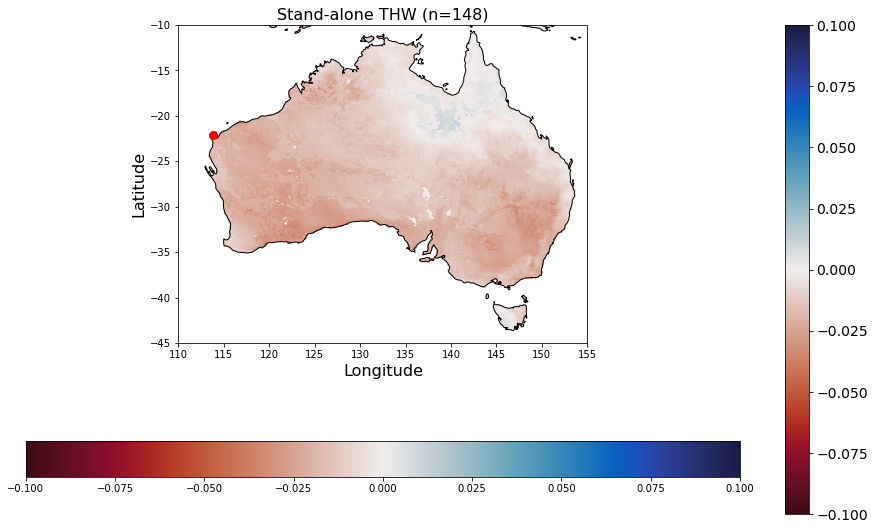

In [147]:
plot_title = 'Stand-alone THW (n=148)'
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-soil-thw.png'
composite_plot(swvl1_nco, plot_title, savefig)

In [76]:
def composite_plot(mslpa_c, sata_c, uwind_c, vwind_c, title, figname):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks([105, 110, 115, 120, 125], crs=ccrs.PlateCarree())
    ax.set_yticks([-30, -25, -20, -15], crs=ccrs.PlateCarree())

    #ploteo=ssta_c.mean(dim='event').plot(
                #cmap=plt.cm.get_cmap('coolwarm', 16), 
                #vmin=-1, vmax=1, # Minimum and maximum values of the colormap
           #)


    ploteo2=mslpa_c.mean(dim='event').plot.contour(
                colors='k',
                levels=30
           )

    ploteo3=sata_c.mean(dim='event').plot(
                cmap=plt.cm.get_cmap('coolwarm', 12), 
                vmin=-6, vmax=6, # Minimum and maximum values of the colormap
           )
    ploteo3.colorbar.ax.set_ylabel('surface air temperature (C)',fontsize=20)
    #ploteo.colorbar.ax.set_ylabel('sea surface temperature anomalies (C)',fontsize=20)
    ploteo3.colorbar.ax.tick_params(labelsize=14)
    #ploteo.colorbar.ax.tick_params(labelsize=14)

    ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
    ax.coastlines()
    ax.set_extent([105, 125, -30, -15],crs=ccrs.PlateCarree())
    # Plotting every 10th data point 
    q = ax.quiver(x[::5], y[::5], uwind_c.mean(dim='event')[::5, ::5], vwind_c.mean(dim='event')[::5, ::5], scale=25, units='height', headwidth=7, headlength=5, headaxislength=4.5)
    plt.quiverkey(q, 0.1, 1.02, 2.5, '2.5 m/s', labelpos='E', fontproperties={'size':14})
    plt.ylabel('Latitude', fontsize=16)
    plt.xlabel('Longitude', fontsize=16)
    plt.title(title, fontsize=16, loc='right')
    # Adding panel subplot alphabet label 
    #ax.text(0.95,1.05,'(%s)' %(ascii_lowercase[b]),
            #horizontalalignment='left',verticalalignment='top',
            #transform = ax.transAxes,fontweight='bold', fontsize=14)
    plt.plot(113.8, -22.1,  markersize=6, marker='o', color='green')
    #plt.show()
    plt.savefig(figname)

In [77]:
#c=6
plot_title = '2 days following stand-alone THW (n=148) end date'
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-mslpa-thw-post-sat.png'
composite_plot(mslpa_nco, sata_nco, uwind_nco, vwind_nco, plot_title, savefig)

NameError: name 'mslpa_nco' is not defined

In [247]:
def composite_plot_hf(slhfa_c, ws_c, title, figname):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks([90, 100, 110, 120, 130], crs=ccrs.PlateCarree())
    ax.set_yticks([-40, -30, -20, -10], crs=ccrs.PlateCarree())

    ploteo=slhfa_c.mean(dim='event').plot(
                cmap=plt.cm.get_cmap('bwr', 12), 
                vmin=-30, vmax=30, # Minimum and maximum values of the colormap
           )


    ploteo2=ws_c.mean(dim='event').plot.contour(
                colors='k',
                levels=10
           )


    ploteo.colorbar.ax.set_ylabel('surface latent heat flux anomalies (Wm-2)',fontsize=20)
    ploteo.colorbar.ax.tick_params(labelsize=14)

    ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
    ax.coastlines()
    ax.set_extent([90, 130, -40, -10],crs=ccrs.PlateCarree())

    plt.ylabel('Latitude', fontsize=16)
    plt.xlabel('Longitude', fontsize=16)
    plt.title(title, fontsize=16, loc='right')
    # Adding panel subplot alphabet label 
    #ax.text(0.95,1.05,'(%s)' %(ascii_lowercase[b]),
            #horizontalalignment='left',verticalalignment='top',
            #transform = ax.transAxes,fontweight='bold', fontsize=14)
    plt.plot(113.75, -22.25,  markersize=6, marker='o', color='green')
    #plt.show()
    plt.savefig(figname)

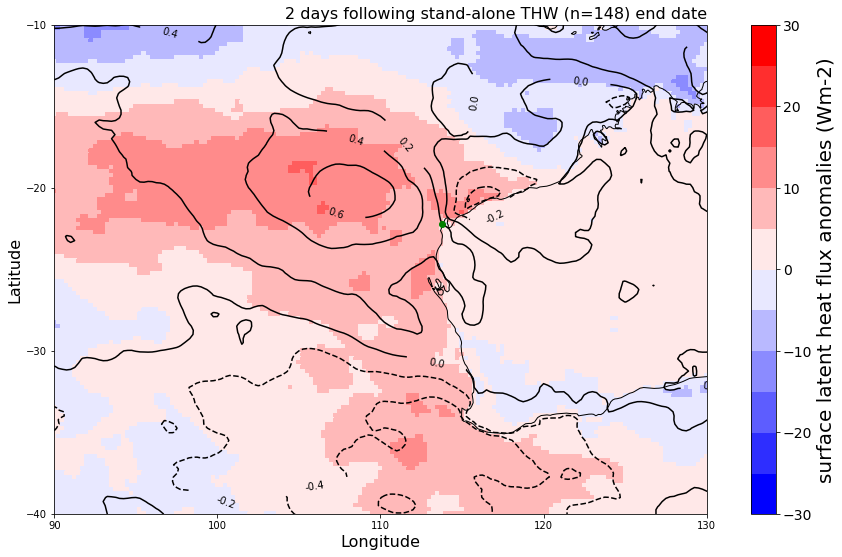

In [248]:
#c=6
plot_title = '2 days following stand-alone THW (n=148) end date'
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-slhfa-thw-post.png'
composite_plot_hf(slhfa_nco, ws_nco, plot_title, savefig)

## Statistical significance of difference in means 

In [114]:
diff_ssta_decay = ssta_co_mhw_buildup.mean(dim='event') - ssta_buildup.mean(dim='event')

In [115]:
# run the Welch's T-Test
r = stats.ttest_ind(ssta_co_mhw_buildup, ssta_buildup, axis=0, equal_var=False, nan_policy='omit')

In [589]:
r = stats.ttest_ind(ssta_co_mhw_decay, 0, axis=0, equal_var=False, nan_policy='omit')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [71]:
# Convert the p-values into a dataarray:
da = xr.DataArray(r[1], dims=('lat', 'lon'), coords={
    'lat': ssta_decay['lat'],
    'lon': ssta_decay['lon']
})

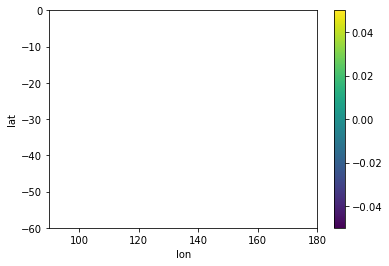

In [72]:
da.plot()

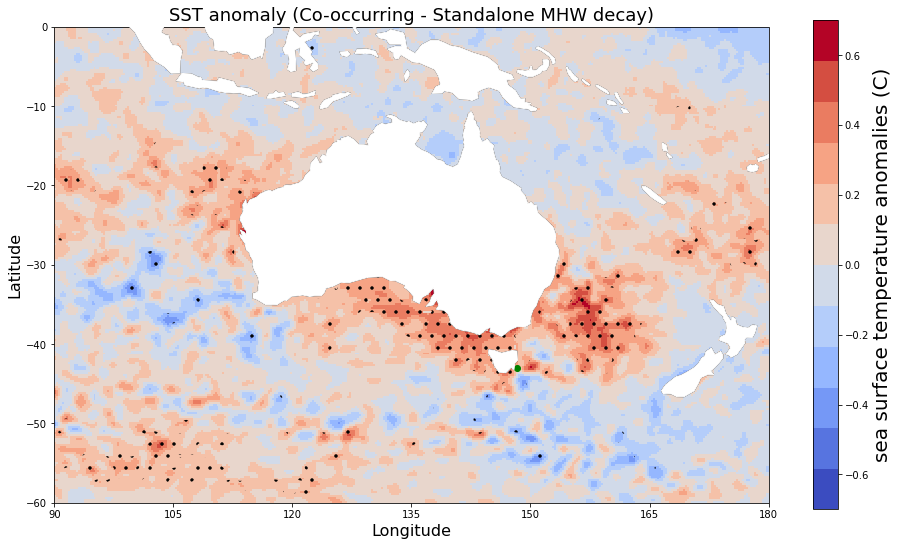

In [419]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo2=diff_ssta_decay.plot(
            cmap=plt.cm.get_cmap('coolwarm', 12), # Specify the colourmap of interest and also the number of discrete levels. I have 5, corresponding to the number of MHW severity categories. See https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html for examples
       )
da.plot.contourf(levels=[0.00, 0.05], hatches=['.', None], colors='none', add_colorbar=False)
ploteo2.colorbar.ax.set_ylabel('sea surface temperature anomalies (C)',fontsize=20)
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('SST anomaly (Co-occurring - Standalone MHW decay)', fontsize=18)
plt.plot(148.25, -43.00,  markersize=6, marker='o', color='green')
#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/Plots/New/hob-ssta-decay-diff.png')

In [168]:
diff_mslpa = mslpa_co.mean(dim='event') - mslpa_nco.mean(dim='event')
diff_ssta = ssta_co.mean(dim='event') - ssta_nco.mean(dim='event')
diff_uwind = uwind_co.mean(dim='event') - uwind_nco.mean(dim='event')
diff_vwind = vwind_co.mean(dim='event') - vwind_nco.mean(dim='event')

In [169]:
# run the Welch's T-Test
r = stats.ttest_ind(mslpa_co, mslpa_nco, axis=0, equal_var=False, nan_policy='omit')

In [170]:
# Convert the p-values into a dataarray:
da = xr.DataArray(r[1], dims=('lat', 'lon'), coords={
    'lat': mslpa_co['lat'],
    'lon': mslpa_co['lon']
})

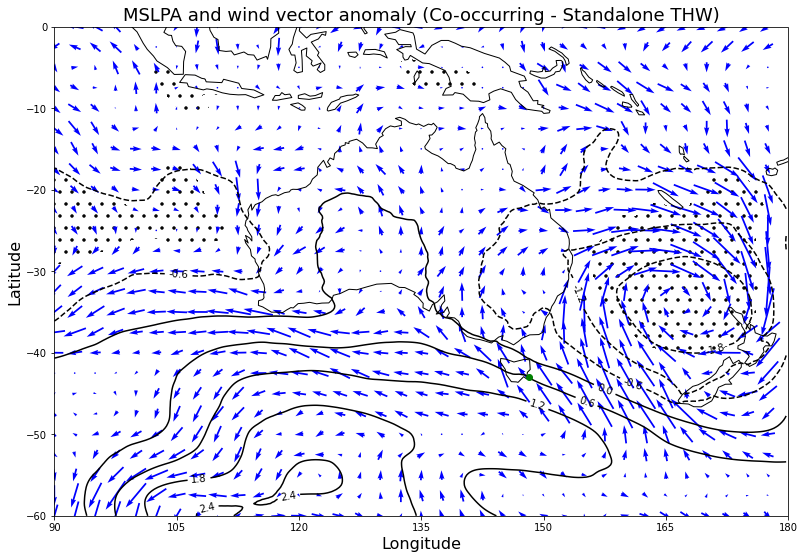

In [253]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
#ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
#ploteo=diff_ssta.plot(
            #cmap=plt.cm.get_cmap('coolwarm', 16), 
            #vmin=-1, vmax=1, # Minimum and maximum values of the colormap
       #)

ploteo2=diff_mslpa.plot.contour(
            #cmap=plt.cm.get_cmap('coolwarm', 12), # Specify the colourmap of interest and also the number of discrete levels. I have 5, corresponding to the number of MHW severity categories. See https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html for examples
            #cmap=cmocean.cm.diff,
            #vmin=-10, vmax=10, # Minimum and maximum values of the colormap
            colors='k',
            levels=10
       )

ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
#ploteo.colorbar.ax.set_ylabel('sea surface temperature anomalies (C)',fontsize=20)
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
da.plot.contourf(levels=[0.00, 0.05], hatches=['.', None], colors='white', add_colorbar=False)
ax.quiver(x[::10], y[::10], diff_uwind[::10, ::10], diff_vwind[::10, ::10], pivot='middle', color='blue')

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('MSLPA and wind vector anomaly (Co-occurring - Standalone THW)', fontsize=18)
plt.plot(148.25, -43.00,  markersize=6, marker='o', color='green')
#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/Plots/New/hob-mslpa-diff.png')

## Specific humidity 

In [147]:
#absolute specific humidity values 
file1 = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-Q/era5_q_1982_2018.nc')
#file2 = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-Q/era5_dailyq_2018_new.nc')
q = file1.q
#q2 = file2.q
#file3 = xr.concat([q1, q2], dim="time")
#q = ds.dailyq

In [148]:
# specific humidity anomaly values 

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-Q/q_anom.nc')
q = ds.q_anomaly

In [149]:
q_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], q.shape[1], q.shape[2])), dims=['event', 'lat', 'lon'])
q_buildup['lat'] = q['latitude'].values
q_buildup['lon'] = q['longitude'].values
q_buildup['event'] = st_mhw_buildup.index.values

for i, e in enumerate(st_mhw_buildup.itertuples()):
    q_buildup[i, :, :] = q.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')

In [150]:
q_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], q.shape[1], q.shape[2])), dims=['event', 'lat', 'lon'])
q_decay['lat'] = q['latitude'].values
q_decay['lon'] = q['longitude'].values
q_decay['event'] = st_mhw_decay.index.values

for i, e in enumerate(st_mhw_decay.itertuples()):
    q_decay[i, :, :] = q.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')


In [269]:
q_nco = xr.DataArray(np.zeros((stand_alone.shape[0], q.shape[1], q.shape[2])), dims=['event', 'lat', 'lon'])
q_nco['lat'] = q['latitude'].values
q_nco['lon'] = q['longitude'].values
q_nco['event'] = stand_alone.index.values
    
for i, e in enumerate(stand_alone.itertuples()):
    q_nco[i, :, :] = q.sel(time=slice(e.time, e.time_end)).mean('time')

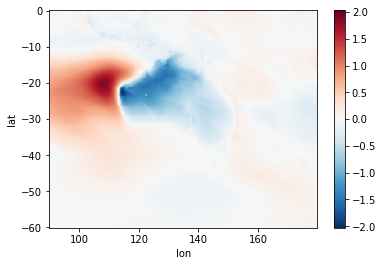

In [148]:
q_nco.mean(dim='event').plot()

In [270]:
def composite_plot_q(q_c, figname):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([90, 130, -40, -10],crs=ccrs.PlateCarree())
    ax.set_xticks([90, 100, 110, 120, 130], crs=ccrs.PlateCarree())
    ax.set_yticks([-40, -30, -20, -10], crs=ccrs.PlateCarree())

    im=q_c.mean(dim='event').plot.contourf(
                levels=np.arange(-2, 2.105, 0.5),
                add_colorbar=False,
                cmap=cmocean.cm.tarn)

    cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-2,2.11,0.5),fraction=0.035,aspect=30) #,format='%.2f')
    cb.set_label(label='Specific humidity anomaly ($\mathregular{g/kg}$)', size=22, weight='normal')
    cb.ax.tick_params(labelsize=20)
    
    plt.ylabel('Latitude', fontsize=20)
    plt.xlabel('Longitude', fontsize=20)
    
    # Adding panel subplot alphabet label 
    #ax.text(0.95,1.05,'(%s)' %(ascii_lowercase[b]),
            #horizontalalignment='left',verticalalignment='top',
            #transform = ax.transAxes,fontweight='normal', fontsize=22)
    plt.plot(113.8, -22.1,  markersize=12, marker='o', color='purple')
    plt.savefig(figname)

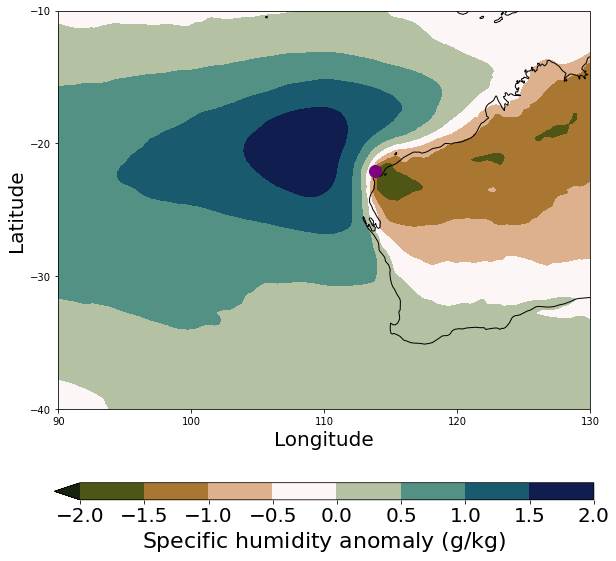

In [272]:
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-q-thw.png'
composite_plot_q(q_nco, savefig)

In [188]:
import cartopy.feature as cfeature

In [208]:
def composite_plot_ssta(ssta_c, figname, b):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([90, 130, -40, -10],crs=ccrs.PlateCarree())
    ax.set_xticks([90, 100, 110, 120, 130], crs=ccrs.PlateCarree())
    ax.set_yticks([-40, -30, -20, -10], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', \
                                                edgecolor='none', facecolor="white"), zorder=1)
    im=ssta_c.mean(dim='event').plot.contourf(
                levels=np.arange(-1, 1.105, 0.25),
                add_colorbar=False,
                cmap=cmocean.cm.balance)

    cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-1,1.11,0.25),fraction=0.035,aspect=30) #,format='%.2f')
    cb.set_label(label=u'Sea surface temperature anomaly (\u00B0C)', size=22, weight='normal')
    cb.ax.tick_params(labelsize=20)
    

    
    plt.ylabel('Latitude', fontsize=20)
    plt.xlabel('Longitude', fontsize=20)
    
    # Adding panel subplot alphabet label 
    ax.text(0.95,1.05,'(%s)' %(ascii_lowercase[b]),
            horizontalalignment='left',verticalalignment='top',
            transform = ax.transAxes,fontweight='normal', fontsize=22)
    plt.plot(113.8, -22.1,  markersize=12, marker='o', color='blue')
    plt.savefig(figname)

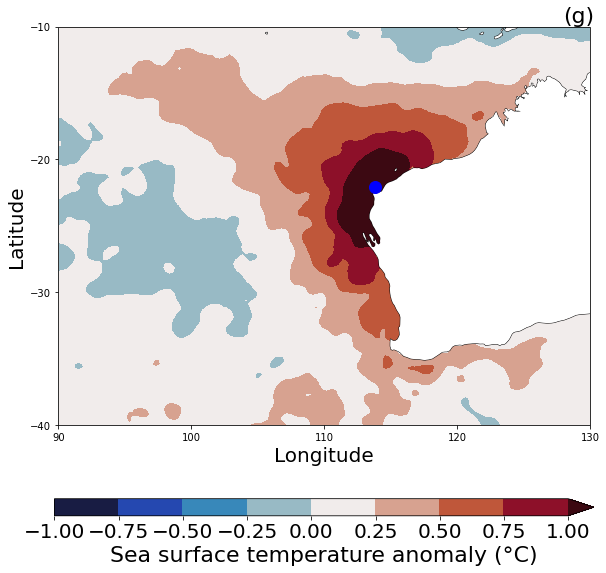

In [210]:
c=6
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-ssta-mhw-b.png'
composite_plot_ssta(ssta_buildup, savefig, c)

## SLHF anomalies

In [122]:
## surface latent heat flux (new)

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-MSLHF/mslhf_anom.nc')
slhf = ds.slhf_anomaly 

In [123]:
## windspeed anomalies

wind_speed = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-WIND/windspeed_anom.nc')

In [124]:
wind_speed_anom = wind_speed.ws_anomaly

In [125]:
slhfa_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_buildup['lat'] = slhf['latitude'].values
slhfa_buildup['lon'] = slhf['longitude'].values
slhfa_buildup['event'] = st_mhw_buildup.index.values

for i, e in enumerate(st_mhw_buildup.itertuples()):
    slhfa_buildup[i, :, :] = slhf.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')

In [126]:
slhfa_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_decay['lat'] = slhf['latitude'].values
slhfa_decay['lon'] = slhf['longitude'].values
slhfa_decay['event'] = st_mhw_decay.index.values

for i, e in enumerate(st_mhw_decay.itertuples()):
    slhfa_decay[i, :, :] = slhf.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')

In [148]:
slhfa_co_buildup = xr.DataArray(np.zeros((thw_mod_b.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_co_buildup['lat'] = slhf['latitude'].values
slhfa_co_buildup['lon'] = slhf['longitude'].values
slhfa_co_buildup['event'] = thw_mod_b.index.values

for i, e in enumerate(thw_mod_b.itertuples()):
    slhfa_co_buildup[i, :, :] = slhf.sel(time=slice(e.time, e.time_end)).mean('time')

In [149]:
slhfa_co_decay = xr.DataArray(np.zeros((thw_mod_d.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_co_decay ['lat'] = slhf['latitude'].values
slhfa_co_decay ['lon'] = slhf['longitude'].values
slhfa_co_decay ['event'] = thw_mod_d.index.values

for i, e in enumerate(thw_mod_d.itertuples()):
    slhfa_co_decay [i, :, :] = slhf.sel(time=slice(e.time, e.time_end)).mean('time')

In [150]:
slhfa_co_mhw_buildup = xr.DataArray(np.zeros((co_mhw_buildup.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_co_mhw_buildup['lat'] = slhf['latitude'].values
slhfa_co_mhw_buildup['lon'] = slhf['longitude'].values
slhfa_co_mhw_buildup['event'] = co_mhw_buildup.index.values

for i, e in enumerate(co_mhw_buildup.itertuples()):
    slhfa_co_mhw_buildup[i, :, :] = slhf.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [151]:
slhfa_co_mhw_decay = xr.DataArray(np.zeros((co_mhw_decay.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_co_mhw_decay['lat'] = slhf['latitude'].values
slhfa_co_mhw_decay['lon'] = slhf['longitude'].values
slhfa_co_mhw_decay['event'] = co_mhw_decay.index.values

for i, e in enumerate(co_mhw_decay.itertuples()):
    slhfa_co_mhw_decay[i, :, :] = slhf.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [261]:
slhfa_nco = xr.DataArray(np.zeros((stand_alone.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_nco['lat'] = slhf['latitude'].values
slhfa_nco['lon'] = slhf['longitude'].values
slhfa_nco['event'] = stand_alone.index.values
    
for i, e in enumerate(stand_alone.itertuples()):
    slhfa_nco[i, :, :] = slhf.sel(time=slice(e.time, e.time_end)).mean('time')

In [127]:
ws_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_buildup['lat'] = wind_speed_anom['latitude'].values
ws_buildup['lon'] = wind_speed_anom['longitude'].values
ws_buildup['event'] = st_mhw_buildup.index.values

for i, e in enumerate(st_mhw_buildup.itertuples()):
    ws_buildup[i, :, :] = wind_speed_anom.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')

In [128]:
ws_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_decay['lat'] = wind_speed_anom['latitude'].values
ws_decay['lon'] = wind_speed_anom['longitude'].values
ws_decay['event'] = st_mhw_decay.index.values

for i, e in enumerate(st_mhw_decay.itertuples()):
    ws_decay[i, :, :] = wind_speed_anom.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')

In [152]:
ws_co_buildup = xr.DataArray(np.zeros((thw_mod_b.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_co_buildup['lat'] = wind_speed_anom['latitude'].values
ws_co_buildup['lon'] = wind_speed_anom['longitude'].values
ws_co_buildup['event'] = thw_mod_b.index.values

for i, e in enumerate(thw_mod_b.itertuples()):
    ws_co_buildup[i, :, :] = wind_speed_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [153]:
ws_co_decay = xr.DataArray(np.zeros((thw_mod_d.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_co_decay['lat'] = wind_speed_anom['latitude'].values
ws_co_decay['lon'] = wind_speed_anom['longitude'].values
ws_co_decay['event'] = thw_mod_d.index.values

for i, e in enumerate(thw_mod_d.itertuples()):
    ws_co_decay[i, :, :] = wind_speed_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [154]:
ws_co_mhw_buildup = xr.DataArray(np.zeros((co_mhw_buildup.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_co_mhw_buildup['lat'] = wind_speed_anom['latitude'].values
ws_co_mhw_buildup['lon'] = wind_speed_anom['longitude'].values
ws_co_mhw_buildup['event'] = co_mhw_buildup.index.values

for i, e in enumerate(co_mhw_buildup.itertuples()):
    ws_co_mhw_buildup[i, :, :] = wind_speed_anom.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [155]:
ws_co_mhw_decay= xr.DataArray(np.zeros((co_mhw_decay.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_co_mhw_decay['lat'] = wind_speed_anom['latitude'].values
ws_co_mhw_decay['lon'] = wind_speed_anom['longitude'].values
ws_co_mhw_decay['event'] = co_mhw_decay.index.values

for i, e in enumerate(co_mhw_decay.itertuples()):
    ws_co_mhw_decay[i, :, :] = wind_speed_anom.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [262]:
ws_nco = xr.DataArray(np.zeros((stand_alone.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_nco['lat'] = wind_speed_anom['latitude'].values
ws_nco['lon'] = wind_speed_anom['longitude'].values
ws_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    ws_nco[i, :, :] = wind_speed_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [265]:
def composite_plot_hf(slhfa_c, ws_c, figname):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([90, 130, -40, -10],crs=ccrs.PlateCarree())
    ax.set_xticks([90, 100, 110, 120, 130], crs=ccrs.PlateCarree())
    ax.set_yticks([-40, -30, -20, -10], crs=ccrs.PlateCarree())
    
    im=slhfa_c.mean(dim='event').plot.contourf(
                levels=np.arange(-30, 30.105, 5),
                add_colorbar=False,
                cmap=plt.cm.get_cmap('bwr', 12))

    
    cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-30,30.11,5),fraction=0.035,aspect=30) #,format='%.2f')
    cb.set_label(label='Latent heat flux anomaly ($\mathregular{Wm^{-2}}$)', size=22, weight='normal')
    cb.ax.tick_params(labelsize=20)
    
    ploteo2=ws_c.mean(dim='event').plot.contour(
                colors='k',
                levels=10
           )

    ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
    plt.ylabel('Latitude', fontsize=20)
    plt.xlabel('Longitude', fontsize=20)

    
    # Adding panel subplot alphabet label 
    #ax.text(0.95,1.05,'(%s)' %(ascii_lowercase[b]),
            #horizontalalignment='left',verticalalignment='top',
            #transform = ax.transAxes,fontweight='normal', fontsize=22)
    plt.plot(113.8, -22.1,  markersize=12, marker='o', color='purple')
    plt.savefig(figname)

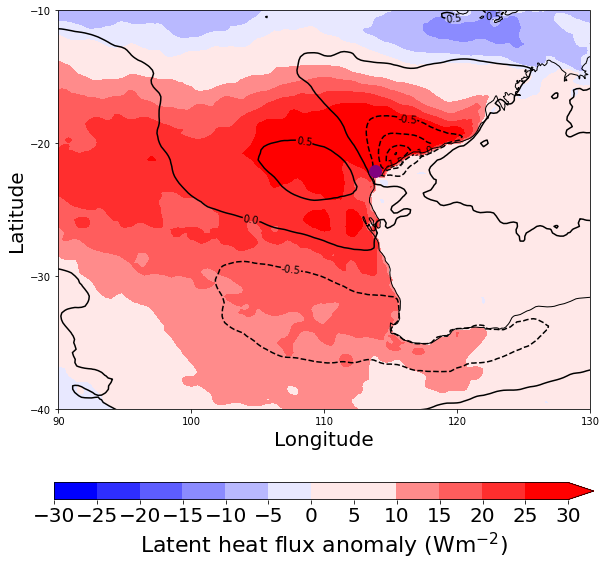

In [267]:
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-slhfa-thw.png'
composite_plot_hf(slhfa_nco, ws_nco, savefig)

In [268]:
diff_slhfa = slhfa_co.mean(dim='event') - slhfa_nco.mean(dim='event')
diff_ws = ws_co.mean(dim='event') - ws_nco.mean(dim='event')

NameError: name 'slhfa_co' is not defined

In [149]:
# run the Welch's T-Test
r = stats.ttest_ind(slhfa_co, slhfa_nco, axis=0, equal_var=False, nan_policy='omit')

In [150]:
# Convert the p-values into a dataarray:
da = xr.DataArray(r[1], dims=('lat', 'lon'), coords={
    'lat': slhfa_co['lat'],
    'lon': slhfa_co['lon']
})

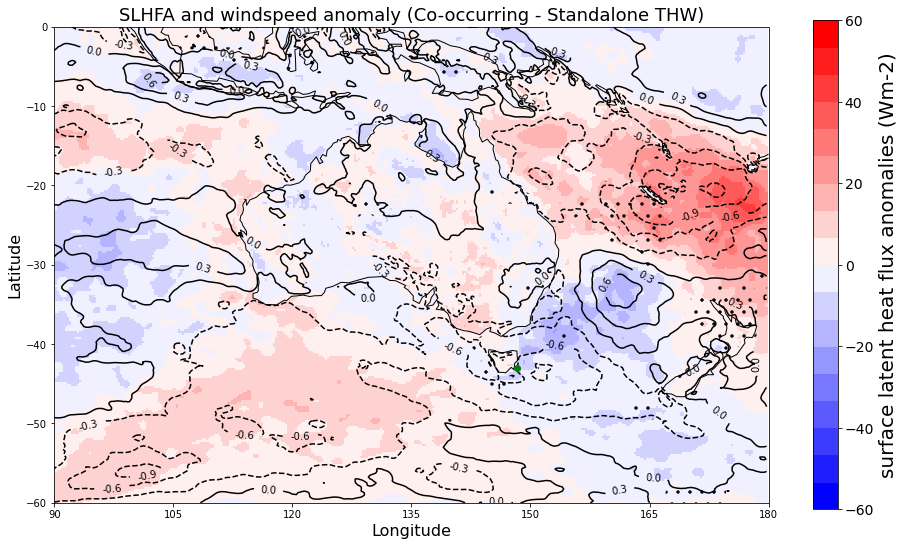

In [273]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=diff_slhfa.plot(
            cmap=plt.cm.get_cmap('bwr', 18), 
            vmin=-60, vmax=60, # Minimum and maximum values of the colormap
       )

ploteo2=diff_ws.plot.contour(
            colors='k',
            levels=10
       )
ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ploteo.colorbar.ax.set_ylabel('surface latent heat flux anomalies (Wm-2)',fontsize=20)
ploteo.colorbar.ax.tick_params(labelsize=14)
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
da.plot.contourf(levels=[0.00, 0.05], hatches=['.', None], colors='none', add_colorbar=False)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('SLHFA and windspeed anomaly (Co-occurring - Standalone THW)', fontsize=18)
plt.plot(148.25, -43.00,  markersize=6, marker='o', color='green')
#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/Plots/New/hob-slhfa-diff.png')

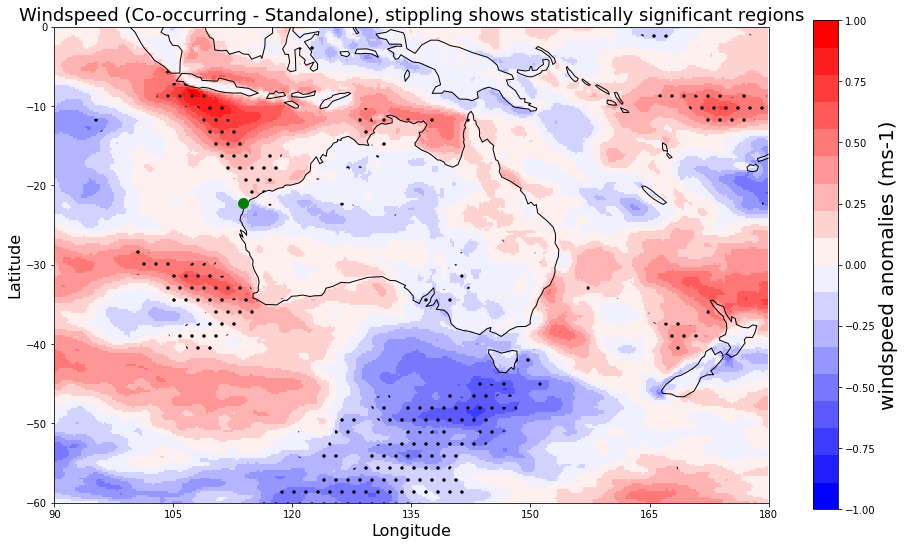

In [204]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=diff_ws.plot(
            cmap=plt.cm.get_cmap('bwr', 18), 
            vmin=-1, vmax=1, # Minimum and maximum values of the colormap
       )

#ploteo2=diff_ws.plot.contour(
            #cmap=plt.cm.get_cmap('coolwarm', 12), # Specify the colourmap of interest and also the number of discrete levels. I have 5, corresponding to the number of MHW severity categories. See https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html for examples
            #cmap=cmocean.cm.diff,
            #vmin=-10, vmax=10, # Minimum and maximum values of the colormap
            #colors='k',
            #levels=10
       #)

ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ploteo.colorbar.ax.set_ylabel('windspeed anomalies (ms-1)',fontsize=20)
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
da.plot.contourf(levels=[0.00, 0.05], hatches=['.', None], colors='none', add_colorbar=False)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Windspeed (Co-occurring - Standalone), stippling shows statistically significant regions', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/Plots/New/speed-diff.png')

## SSHF anomalies 

In [109]:
## surface sensible heat flux 

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-MSSHF/msshf_anom2.nc')
sshfa = ds.sshf_anomaly 

In [110]:
sshfa_nco = xr.DataArray(np.zeros((stand_alone.shape[0], sshfa.shape[1], sshfa.shape[2])), dims=['event', 'lat', 'lon'])
sshfa_nco['lat'] = sshfa['latitude'].values
sshfa_nco['lon'] = sshfa['longitude'].values
sshfa_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    sshfa_nco[i, :, :] = sshfa.sel(time=slice(e.time, e.time_end)).mean('time')

In [111]:
sshfa_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], sshfa.shape[1], sshfa.shape[2])), dims=['event', 'lat', 'lon'])
sshfa_buildup['lat'] = sshfa['latitude'].values
sshfa_buildup['lon'] = sshfa['longitude'].values
sshfa_buildup['event'] = st_mhw_buildup.index.values

for i, e in enumerate(st_mhw_buildup.itertuples()):
    sshfa_buildup[i, :, :] = sshfa.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')

In [112]:
sshfa_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], sshfa.shape[1], sshfa.shape[2])), dims=['event', 'lat', 'lon'])
sshfa_decay['lat'] = sshfa['latitude'].values
sshfa_decay['lon'] = sshfa['longitude'].values
sshfa_decay['event'] = st_mhw_decay.index.values

for i, e in enumerate(st_mhw_decay.itertuples()):
    sshfa_decay[i, :, :] = sshfa.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')

In [177]:
sshfa_co_buildup = xr.DataArray(np.zeros((thw_mod_b.shape[0], sshfa.shape[1], sshfa.shape[2])), dims=['event', 'lat', 'lon'])
sshfa_co_buildup['lat'] = sshfa['latitude'].values
sshfa_co_buildup['lon'] = sshfa['longitude'].values
sshfa_co_buildup['event'] = thw_mod_b.index.values

for i, e in enumerate(thw_mod_b.itertuples()):
    sshfa_co_buildup[i, :, :] = sshfa.sel(time=slice(e.time, e.time_end)).mean('time')

In [176]:
sshfa_co_decay = xr.DataArray(np.zeros((thw_mod_d.shape[0], sshfa.shape[1], sshfa.shape[2])), dims=['event', 'lat', 'lon'])
sshfa_co_decay['lat'] = sshfa['latitude'].values
sshfa_co_decay['lon'] = sshfa['longitude'].values
sshfa_co_decay['event'] = thw_mod_d.index.values

for i, e in enumerate(thw_mod_d.itertuples()):
    sshfa_co_decay[i, :, :] = sshfa.sel(time=slice(e.time, e.time_end)).mean('time')

In [174]:
sshfa_co_mhw_buildup = xr.DataArray(np.zeros((co_mhw_buildup.shape[0], sshfa.shape[1], sshfa.shape[2])), dims=['event', 'lat', 'lon'])
sshfa_co_mhw_buildup['lat'] = sshfa['latitude'].values
sshfa_co_mhw_buildup['lon'] = sshfa['longitude'].values
sshfa_co_mhw_buildup['event'] = co_mhw_buildup.index.values

for i, e in enumerate(co_mhw_buildup.itertuples()):
    sshfa_co_mhw_buildup[i, :, :] = sshfa.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [175]:
sshfa_co_mhw_decay = xr.DataArray(np.zeros((co_mhw_decay.shape[0], sshfa.shape[1], sshfa.shape[2])), dims=['event', 'lat', 'lon'])
sshfa_co_mhw_decay['lat'] = sshfa['latitude'].values
sshfa_co_mhw_decay['lon'] = sshfa['longitude'].values
sshfa_co_mhw_decay['event'] = co_mhw_decay.index.values

for i, e in enumerate(co_mhw_decay.itertuples()):
    sshfa_co_mhw_decay[i, :, :] = sshfa.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

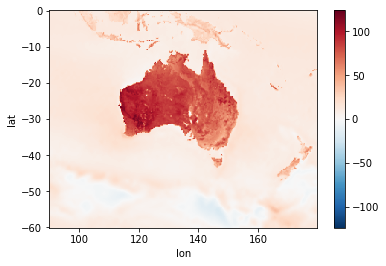

In [334]:
sshfa_nco.mean(dim='event').plot()

In [118]:
def composite_plot_sshf(sshfa_c, b, title, figname):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks([90, 100, 110, 120, 130], crs=ccrs.PlateCarree())
    ax.set_yticks([-40, -30, -20, -10], crs=ccrs.PlateCarree())

    ploteo=sshfa_c.mean(dim='event').plot(
                cmap=plt.cm.get_cmap('bwr', 12), 
                vmin=-30, vmax=30, # Minimum and maximum values of the colormap
           )

    ploteo.colorbar.ax.set_ylabel('surface sensible heat flux anomalies (Wm-2)',fontsize=20)
    ploteo.colorbar.ax.tick_params(labelsize=14)

    ax.coastlines()
    ax.set_extent([90, 130, -40, -10],crs=ccrs.PlateCarree())

    plt.ylabel('Latitude', fontsize=16)
    plt.xlabel('Longitude', fontsize=16)
    plt.title(title, fontsize=16)
    # Adding panel subplot alphabet label 
    ax.text(0.95,1.05,'(%s)' %(ascii_lowercase[b]),
            horizontalalignment='left',verticalalignment='top',
            transform = ax.transAxes,fontweight='bold', fontsize=14)
    plt.plot(113.75, -22.25,  markersize=6, marker='o', color='green')
    #plt.show()
    plt.savefig(figname)

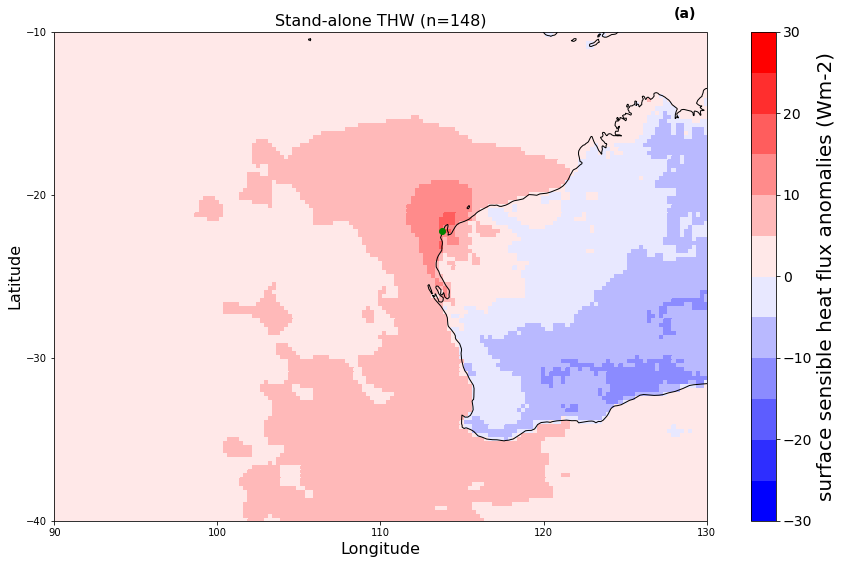

In [121]:
c=0
plot_title = 'Stand-alone THW (n=148)'
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-sshfa-thw.png'
composite_plot_sshf(sshfa_nco, c, plot_title, savefig)

## Shortwave radiation downward anomalies (ssrd)

In [71]:
## shortwave radiation 

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-SSRD/ssrd_anom.nc')
ssrd = ds.ssrd_anomaly 

In [72]:
ssrd_buildup = xr.DataArray(np.zeros((st_mhw_buildup.shape[0], ssrd.shape[1], ssrd.shape[2])), dims=['event', 'lat', 'lon'])
ssrd_buildup['lat'] = ssrd['latitude'].values
ssrd_buildup['lon'] = ssrd['longitude'].values
ssrd_buildup['event'] = st_mhw_buildup.index.values

for i, e in enumerate(st_mhw_buildup.itertuples()):
    ssrd_buildup[i, :, :] = ssrd.sel(time=slice(e.time_mhw, e.time_peak_mhw)).mean('time')

In [73]:
ssrd_decay = xr.DataArray(np.zeros((st_mhw_decay.shape[0], ssrd.shape[1], ssrd.shape[2])), dims=['event', 'lat', 'lon'])
ssrd_decay['lat'] = ssrd['latitude'].values
ssrd_decay['lon'] = ssrd['longitude'].values
ssrd_decay['event'] = st_mhw_decay.index.values

for i, e in enumerate(st_mhw_decay.itertuples()):
    ssrd_decay[i, :, :] = ssrd.sel(time=slice(e.time_peak_mhw, e.time_end_mhw)).mean('time')

In [285]:
ssrd_co_buildup = xr.DataArray(np.zeros((thw_mod_b.shape[0], ssrd.shape[1], ssrd.shape[2])), dims=['event', 'lat', 'lon'])
ssrd_co_buildup ['lat'] = ssrd['latitude'].values
ssrd_co_buildup ['lon'] = ssrd['longitude'].values
ssrd_co_buildup ['event'] = thw_mod_b.index.values

for i, e in enumerate(thw_mod_b.itertuples()):
    ssrd_co_buildup [i, :, :] = ssrd.sel(time=slice(e.time, e.time_end)).mean('time')

In [286]:
ssrd_co_decay = xr.DataArray(np.zeros((thw_mod_d.shape[0], ssrd.shape[1], ssrd.shape[2])), dims=['event', 'lat', 'lon'])
ssrd_co_decay['lat'] = ssrd['latitude'].values
ssrd_co_decay['lon'] = ssrd['longitude'].values
ssrd_co_decay['event'] = thw_mod_d.index.values

for i, e in enumerate(thw_mod_d.itertuples()):
    ssrd_co_decay[i, :, :] = ssrd.sel(time=slice(e.time, e.time_end)).mean('time')

In [278]:
ssrd_co_mhw_buildup = xr.DataArray(np.zeros((co_mhw_buildup.shape[0], ssrd.shape[1], ssrd.shape[2])), dims=['event', 'lat', 'lon'])
ssrd_co_mhw_buildup ['lat'] = ssrd['latitude'].values
ssrd_co_mhw_buildup ['lon'] = ssrd['longitude'].values
ssrd_co_mhw_buildup ['event'] = co_mhw_buildup.index.values

for i, e in enumerate(co_mhw_buildup.itertuples()):
    ssrd_co_mhw_buildup [i, :, :] = ssrd.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [279]:
ssrd_co_mhw_decay = xr.DataArray(np.zeros((co_mhw_decay.shape[0], ssrd.shape[1], ssrd.shape[2])), dims=['event', 'lat', 'lon'])
ssrd_co_mhw_decay ['lat'] = ssrd['latitude'].values
ssrd_co_mhw_decay ['lon'] = ssrd['longitude'].values
ssrd_co_mhw_decay ['event'] = co_mhw_decay.index.values

for i, e in enumerate(co_mhw_decay.itertuples()):
    ssrd_co_mhw_decay [i, :, :] = ssrd.sel(time=slice(e.time_mhw, e.time_end_mhw)).mean('time')

In [74]:
ssrd_nco = xr.DataArray(np.zeros((stand_alone.shape[0], ssrd.shape[1], ssrd.shape[2])), dims=['event', 'lat', 'lon'])
ssrd_nco['lat'] = ssrd['latitude'].values
ssrd_nco['lon'] = ssrd['longitude'].values
ssrd_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    ssrd_nco[i, :, :] = ssrd.sel(time=slice(e.time, e.time_end)).mean('time')

In [75]:
def composite_plot_ssrd(ssrd_c, b, title, figname):
    fig, ax = plt.subplots(figsize=(16,9))    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks([90, 100, 110, 120, 130], crs=ccrs.PlateCarree())
    ax.set_yticks([-40, -30, -20, -10], crs=ccrs.PlateCarree())

    ploteo=ssrd_c.mean(dim='event').plot(
                cmap=plt.cm.get_cmap('bwr', 12), 
                vmin=-30, vmax=30, # Minimum and maximum values of the colormap
           )

    ploteo.colorbar.ax.set_ylabel('shortwave radiation downwards anomalies (Wm-2)',fontsize=20)
    ploteo.colorbar.ax.tick_params(labelsize=14)

    ax.coastlines()
    ax.set_extent([90, 130, -40, -10],crs=ccrs.PlateCarree())

    plt.ylabel('Latitude', fontsize=16)
    plt.xlabel('Longitude', fontsize=16)
    plt.title(title, fontsize=16)
    # Adding panel subplot alphabet label 
    ax.text(0.95,1.05,'(%s)' %(ascii_lowercase[b]),
            horizontalalignment='left',verticalalignment='top',
            transform = ax.transAxes,fontweight='bold', fontsize=14)
    plt.plot(113.75, -22.25,  markersize=6, marker='o', color='green')
    #plt.show()
    plt.savefig(figname)

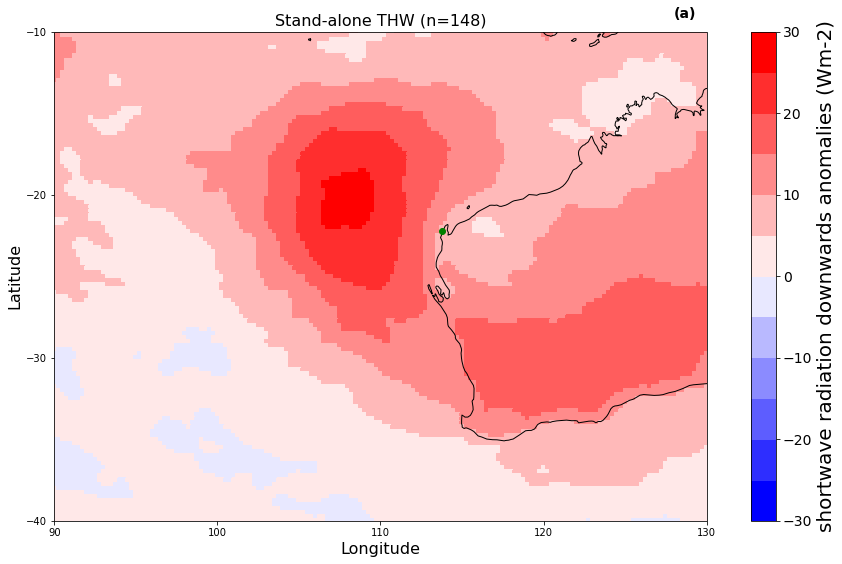

In [78]:
c=0
plot_title = 'Stand-alone THW (n=148)'
savefig = '/g/data/e14/cp3790/Charuni/Plots/New/nin-ssrd-thw.png'
composite_plot_ssrd(ssrd_nco, c, plot_title, savefig)

## Wind component parallel to coastline

In [130]:
import xarray.ufuncs as xu
import math 

In [131]:
# absolute wind values

ds_u10 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-WIND/u10/era5_dailyu10_*.nc').sel(latitude=lat, longitude=lon, method='nearest')
u10 = ds_u10.u10
ds_v10 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-WIND/v10/era5_dailyv10_*.nc').sel(latitude=lat, longitude=lon, method='nearest')
v10 = ds_v10.v10

In [132]:
# wind anomalies 

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/ERA5-WIND/u10-new/uwind_anom.nc').sel(latitude=lat, longitude=lon, method='nearest')
uwind_anom = ds.uwind_anomaly 
ds2 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ERA5-WIND/v10-new/vwind_anom.nc').sel(latitude=lat, longitude=lon, method='nearest')
vwind_anom = ds2.vwind_anomaly

In [146]:
v_mean = v10.values.mean()
u_mean = u10.values.mean()

In [134]:
u_anom_mean = uwind_anom.mean()
v_anom_mean = vwind_anom.mean()

In [137]:
# calculating alpha using absolute values
alpha = math.degrees(math.atan(v_anom_mean/u_anom_mean))
alpha

-86.3636807206167

In [150]:
# calculating windspeed using wind anomalies 
wind_speed = xu.sqrt(uwind_anom**2+vwind_anom**2)
wind_strength = wind_speed*(math.cos(math.radians(120-abs(alpha))))

In [151]:
wind_strength = wind_strength.values
lon = lon
lat = lat
time = pd.date_range("1982-01-01", periods=13514)

In [152]:
da = xr.DataArray(
    data=wind_strength,
    dims=["time"],
    coords=dict(
        lon=(lon),
        lat=(lat),
        time=time,
    )
)

In [153]:
da

<xarray.DataArray (time: 13514)>
array([1.4380938 , 0.49172428, 0.79125196, ..., 2.5020356 , 2.150575  ,
       1.5585289 ], dtype=float32)
Coordinates:
    lon      float64 113.9
    lat      float64 -22.12
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-31

In [158]:
st_mhw_buildup['time_peak_mhw'] = pd.to_datetime(st_mhw_buildup['time_peak_mhw'])
st_mhw_buildup['event_duration'] = (st_mhw_buildup['time_peak_mhw'] - st_mhw_buildup['time_mhw']).dt.days+1
st_mhw_buildup['time'] = ((st_mhw_buildup['time_mhw'] - (pd.to_datetime('1982-1-1')))/np.timedelta64(1, 'D')).astype(int)

In [159]:
st_mhw_decay['time_peak_mhw'] = pd.to_datetime(st_mhw_decay['time_peak_mhw'])
st_mhw_decay['event_duration'] = (st_mhw_decay['time_end_mhw'] - st_mhw_decay['time_peak_mhw']).dt.days+1
st_mhw_decay['time'] = ((st_mhw_decay['time_peak_mhw'] - (pd.to_datetime('1982-1-1')))/np.timedelta64(1, 'D')).astype(int)

In [158]:
thw_mod_b['event_duration'] = (thw_mod_b['time_end'] - thw_mod_b['time']).dt.days+1
thw_mod_b['time'] = ((thw_mod_b['time'] - (pd.to_datetime('1982-1-1')))/np.timedelta64(1, 'D')).astype(int)

In [159]:
thw_mod_d['event_duration'] = (thw_mod_d['time_end'] - thw_mod_d['time']).dt.days+1
thw_mod_d['time'] = ((thw_mod_d['time'] - (pd.to_datetime('1982-1-1')))/np.timedelta64(1, 'D')).astype(int)

In [160]:
co_mhw_buildup['event_duration'] = (co_mhw_buildup['time_end_mhw'] - co_mhw_buildup['time_mhw']).dt.days+1
co_mhw_buildup['time'] = ((co_mhw_buildup['time_mhw'] - (pd.to_datetime('1982-1-1')))/np.timedelta64(1, 'D')).astype(int)

In [161]:
co_mhw_decay['event_duration'] = (co_mhw_decay['time_end_mhw'] - co_mhw_decay['time_mhw']).dt.days+1
co_mhw_decay['time'] = ((co_mhw_decay['time_mhw'] - (pd.to_datetime('1982-1-1')))/np.timedelta64(1, 'D')).astype(int)

In [168]:
stand_alone['event_duration'] = (stand_alone['time_end'] - stand_alone['time']).dt.days+1
stand_alone['time'] = ((stand_alone['time'] - (pd.to_datetime('1982-1-1')))/np.timedelta64(1, 'D')).astype(int)

In [171]:
mean_wind = (climtas.event.map_events(da, stand_alone, lambda x: {'mean_wind': x.mean().item()})).mean()
mean_wind

mean_wind    1.832438
dtype: float64